In [20]:
%matplotlib notebook
import CoolProp 
from CoolProp.CoolProp import PropsSI
import pandas as pd
import numpy as np
import glob,sys,socket,fileinput
import os.path
import matplotlib.pyplot as plt
import scipy as sp
from scipy.fft import rfft,rfftfreq,irfft

In [21]:
D=50/1000 #Diametro de la parte cilindrica [m]
T=273.15+26
rho=PropsSI('D', 'T',T , 'P', 1e5, 'AIR') #Densidad del aire [kg/m3]
mu=PropsSI('V', 'T', T, 'P', 1e5, 'AIR') #Viscocidad del aire [Pa. s]
L=0.175*2 #Largo del cilindro en metros
A=D*L ## area proyectada

In [28]:
# en calibrationData va el nombre del archivo que 
CDfile = "CD.txt"
CDData=open(CDfile,"w")
#CDData.write('txt,Media Lift,Media Drag,STD Lift,STD Drag\n');
CDData.write('txt,MediaLift,MediaDrag\n');

In [29]:
VelocityFile = "Velocidades Calibradas/Velocidades.txt"
VelocityData = pd.read_csv(VelocityFile)
PolinomioVelocidad=np.polyfit(VelocityData["V [V]"],VelocityData["U [m/s]"],1)

In [30]:
RawDataFolder = "Raw Data/"
files = np.sort(glob.glob(RawDataFolder+'*.txt'))
VoltajeMedicion=[]
VelocidadMedicion=[]
ReMedicion=[]
for i in files:
    item=i.strip("Raw Data\\V")
    item=item.strip(".txt")
    item=item.strip("")
    VoltajeMedicion.append(float(item))
    Vitem=PolinomioVelocidad[0]*float(item)+PolinomioVelocidad[1]
    VelocidadMedicion.append(Vitem)
    ReMedicion.append(Vitem*D*rho/mu)

In [31]:
Inicial= {
    "Voltaje" : VoltajeMedicion,
    "Velocidad" : VelocidadMedicion,
    "Re" : ReMedicion,
    }
DFInicial = pd.DataFrame(Inicial)
DFInicial

Voltaje  Velocidad            Re
0      0.00  -0.120047   -378.033360
1     25.00   2.167614   6825.935609
2     26.01   2.260036   7116.975955
3     28.00   2.442134   7690.411885
4     30.00   2.625147   8266.729403
5     32.00   2.808159   8843.046920
6     34.00   2.991172   9419.364438
7     36.00   3.174185   9995.681955
8     38.00   3.357198  10571.999473
9     40.00   3.540211  11148.316990
10    42.00   3.723224  11724.634508
11    44.00   3.906237  12300.952025
12    46.00   4.089250  12877.269543
13    48.00   4.272262  13453.587060
14    50.00   4.455275  14029.904578

<IPython.core.display.Javascript object>


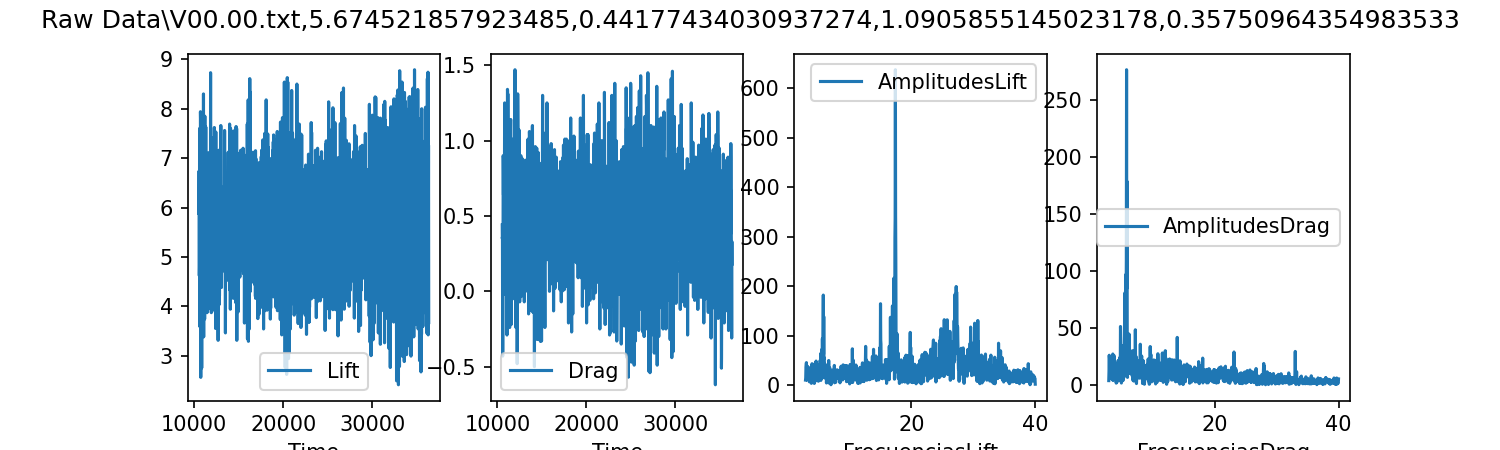

<IPython.core.display.Javascript object>


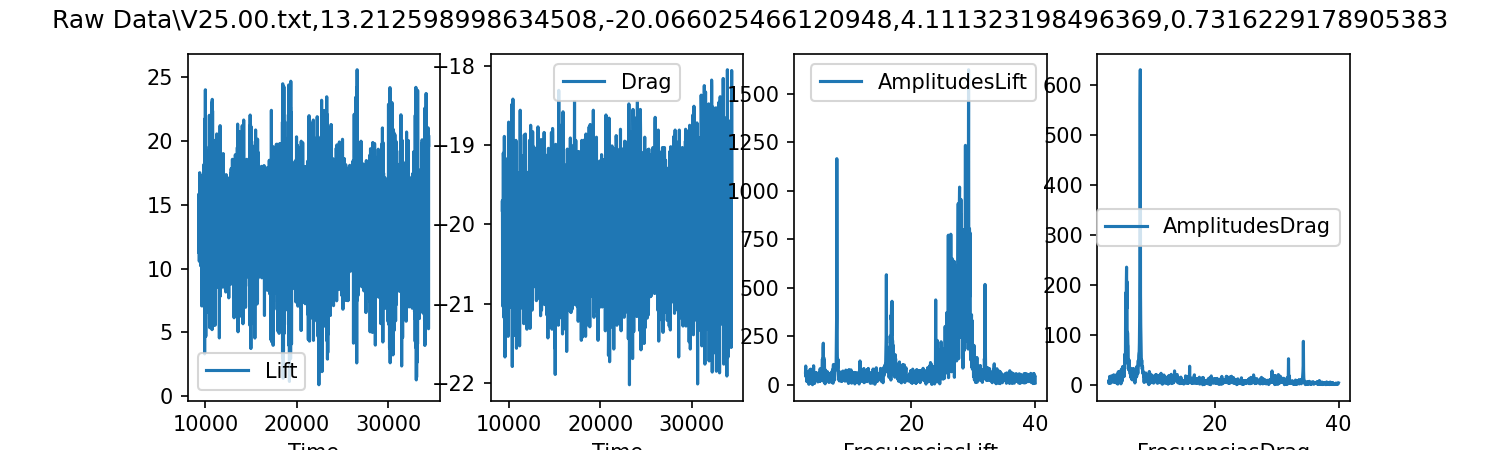

<IPython.core.display.Javascript object>


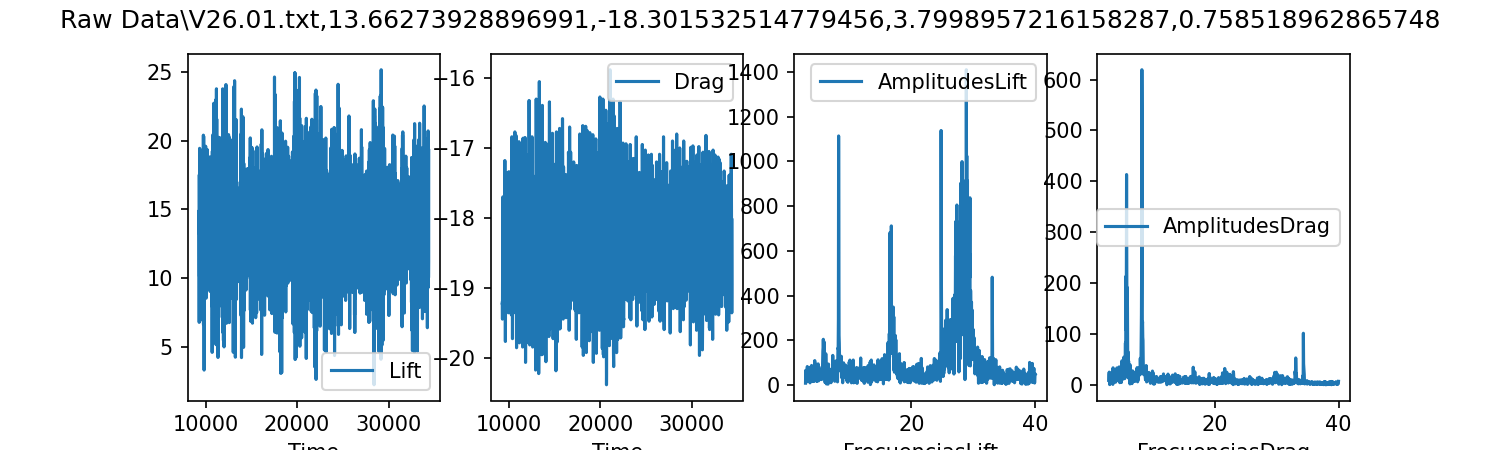

<IPython.core.display.Javascript object>


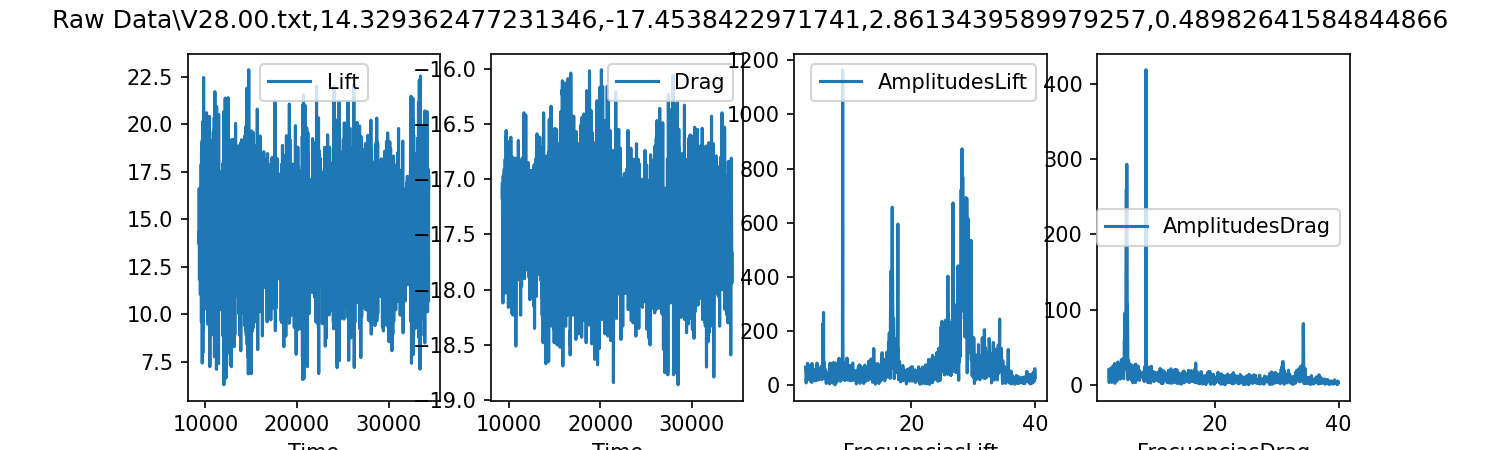

<IPython.core.display.Javascript object>


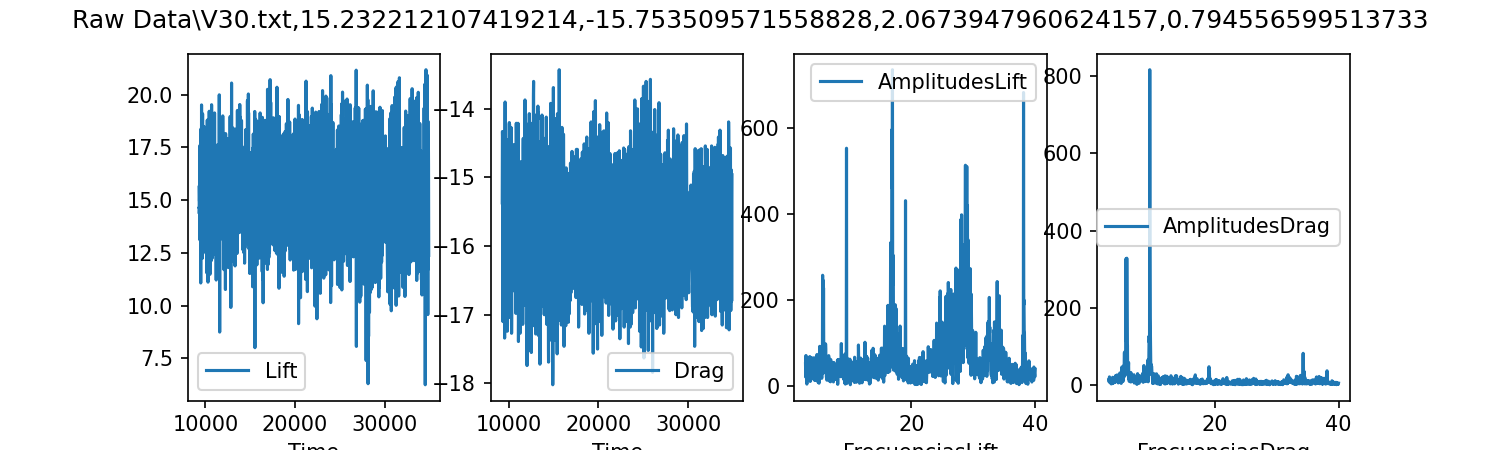

<IPython.core.display.Javascript object>


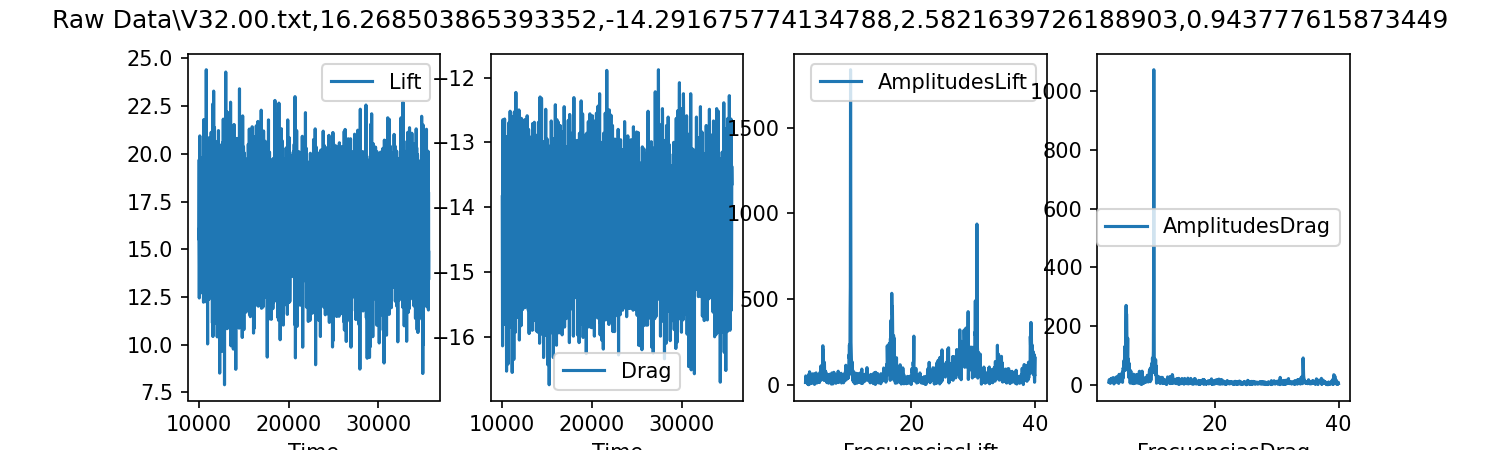

<IPython.core.display.Javascript object>


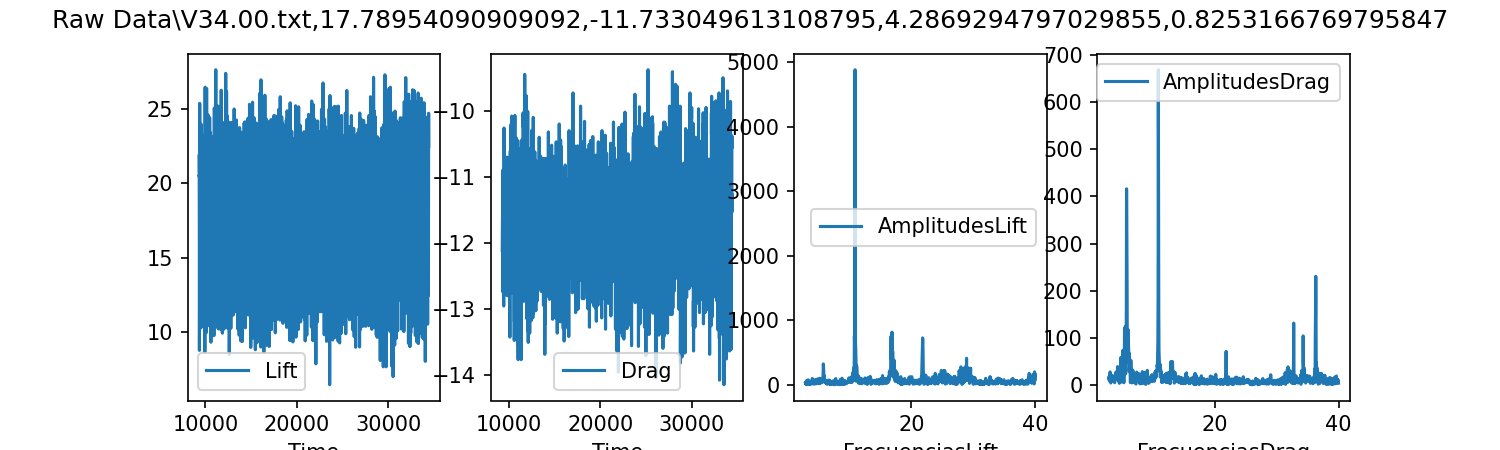

<IPython.core.display.Javascript object>


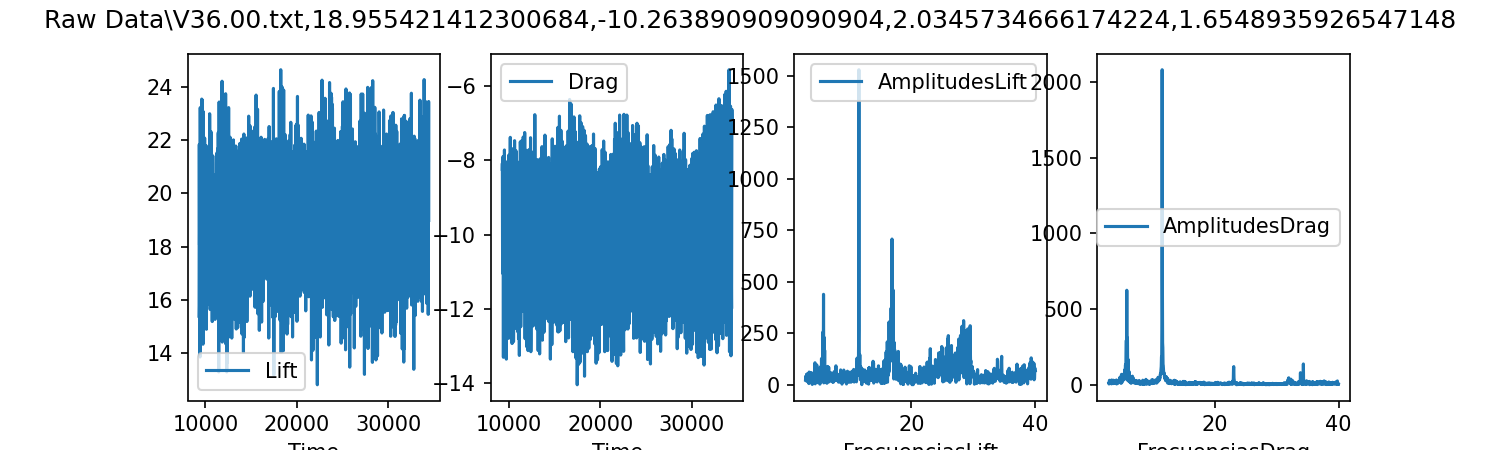

<IPython.core.display.Javascript object>


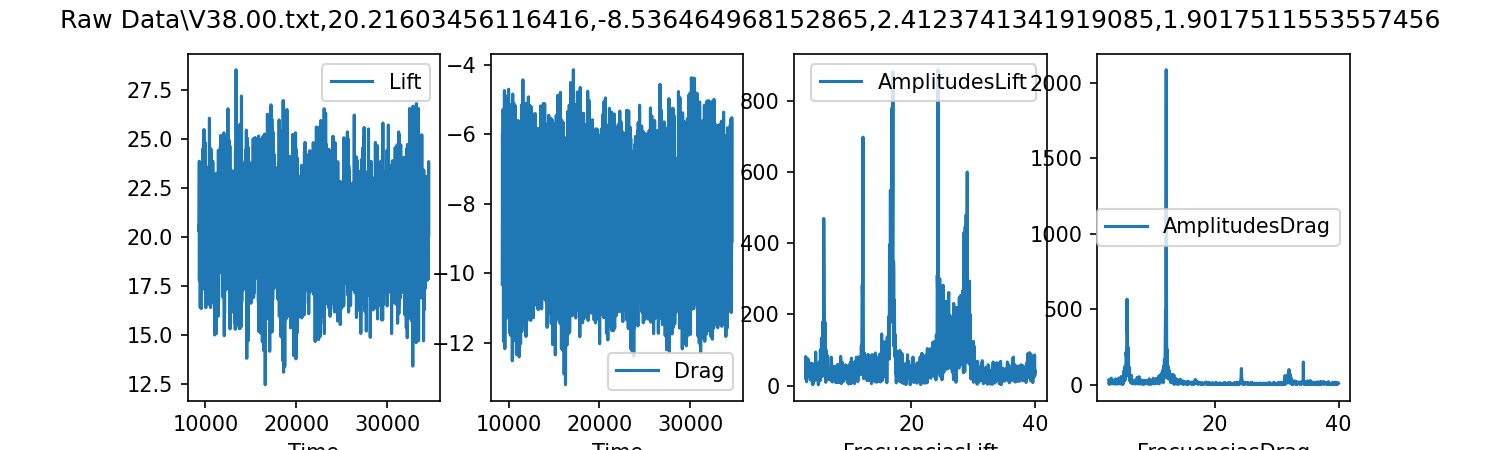

<IPython.core.display.Javascript object>


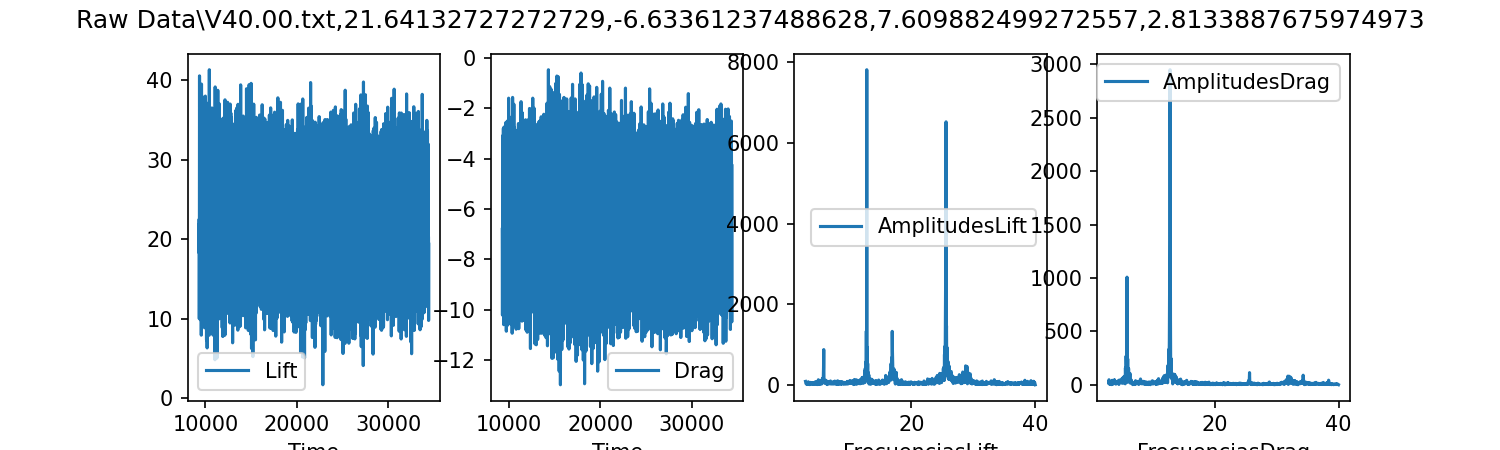

<IPython.core.display.Javascript object>


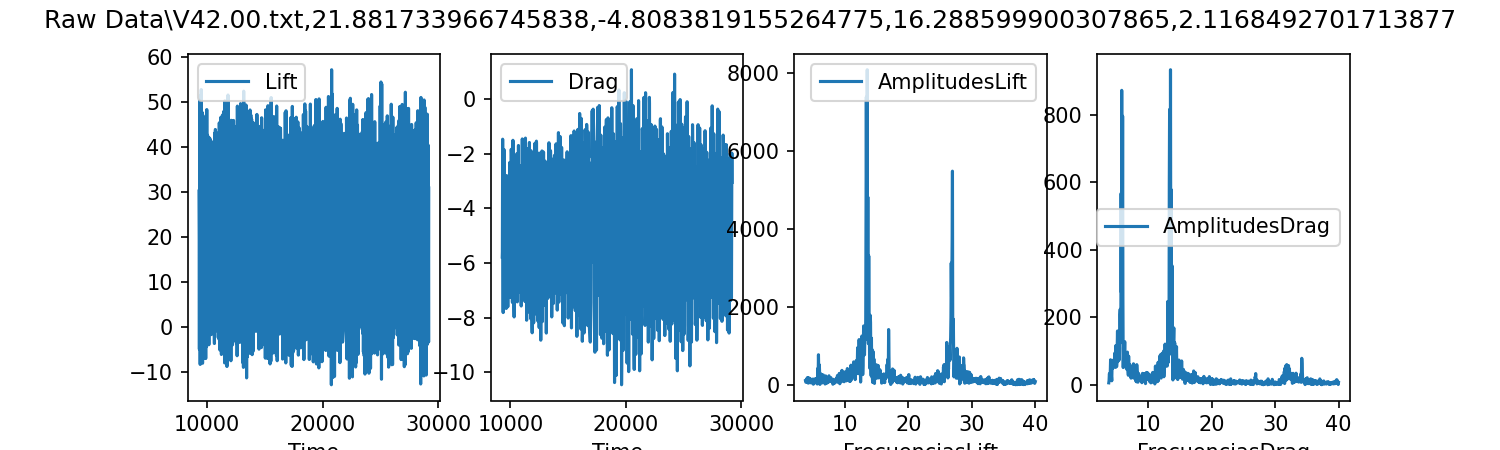

<IPython.core.display.Javascript object>


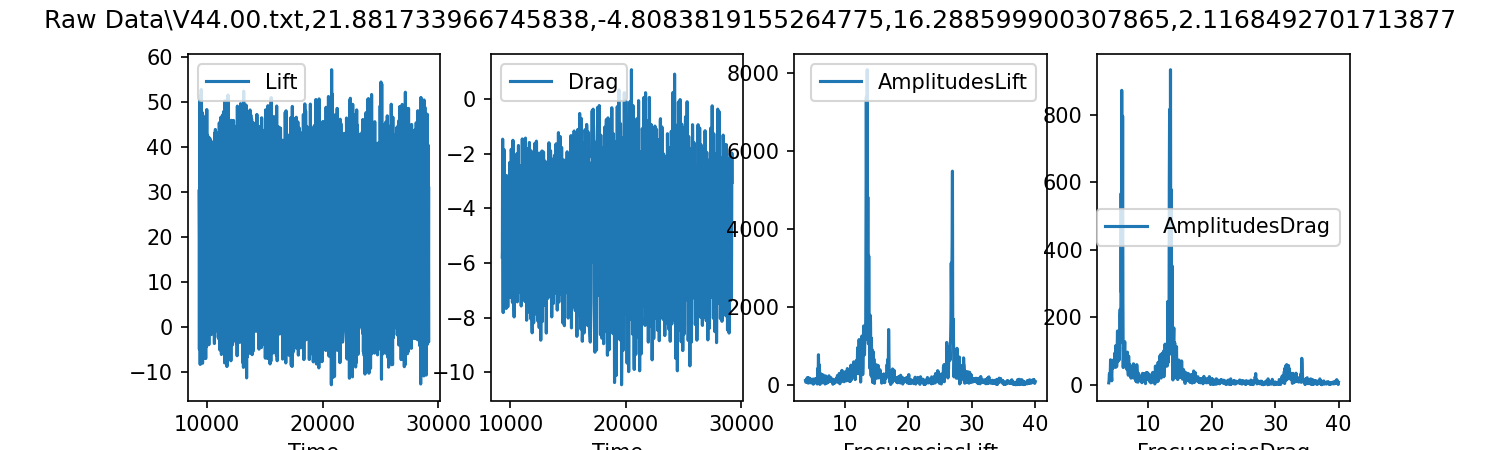

<IPython.core.display.Javascript object>


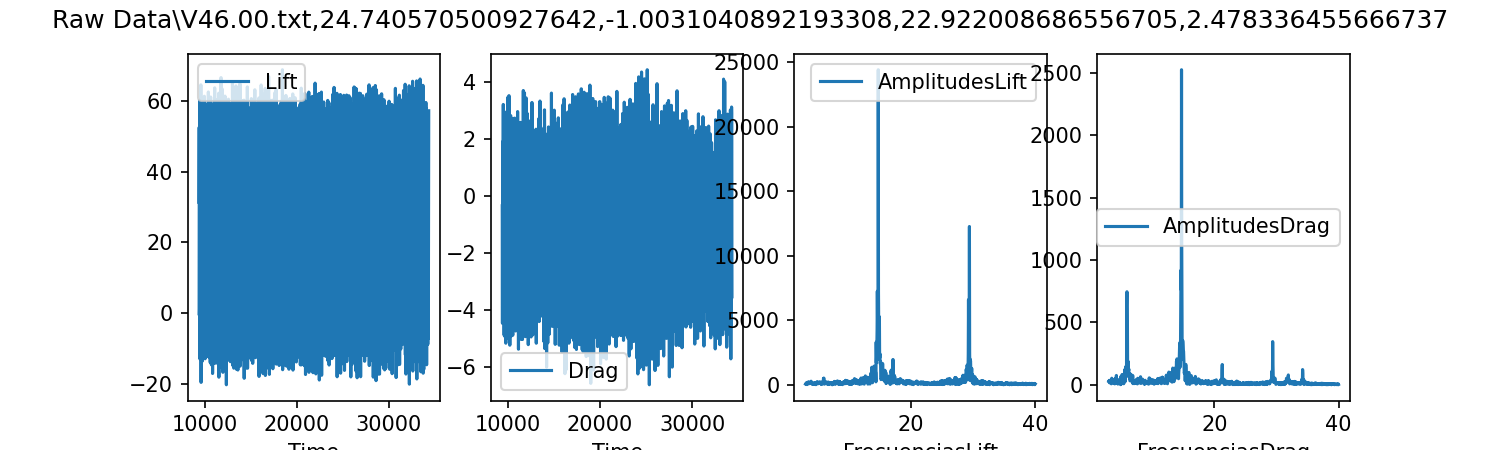

<IPython.core.display.Javascript object>


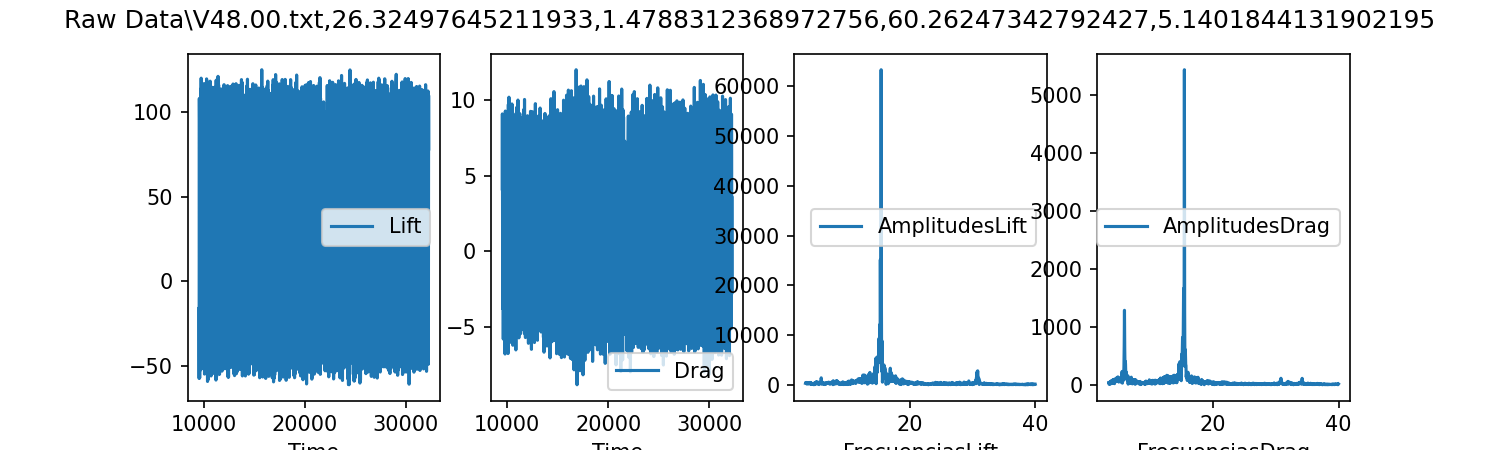

<IPython.core.display.Javascript object>


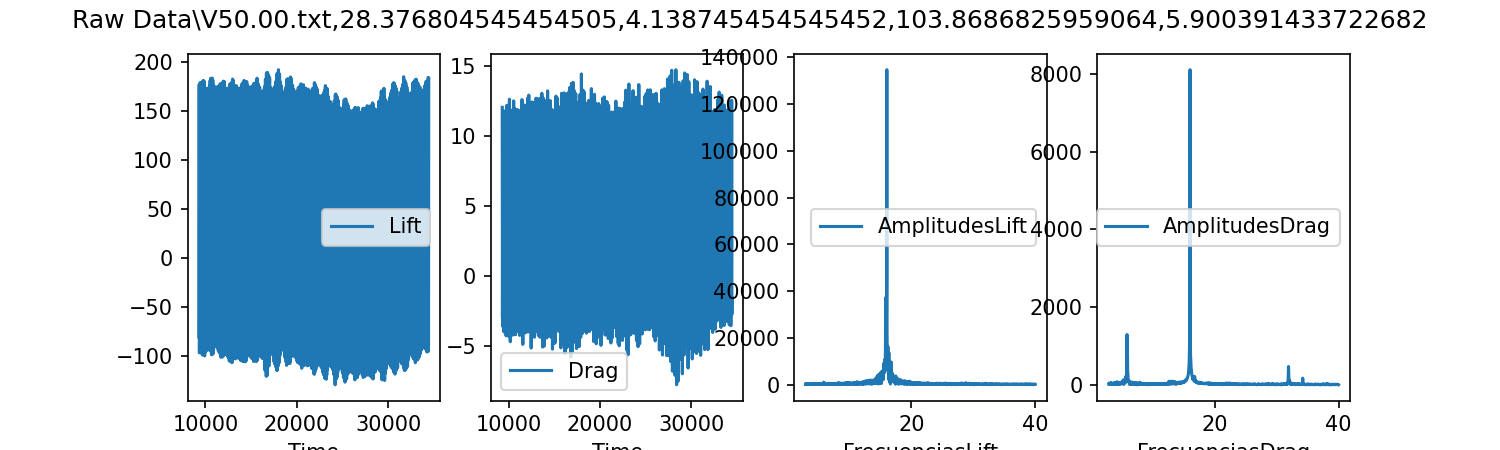

In [32]:
for k in files:
    datos = pd.read_csv(k, sep=",", header=None,skiprows=5)
    datos = datos[:-100]
    datos.columns = ["Lift", "Drag", "Time"]
    datos = datos.astype(float)
    datos=datos[800:3000]
    mediaLift=datos["Lift"].mean()
    stdLift=datos["Lift"].std()
    mediaDrag=(datos["Drag"].mean())
    stdDrag=(datos["Drag"].std())
    df=datos
    
 
    
    for i in df.index:
        if df["Lift"][i]>(mediaLift+3*stdLift):
            df["Lift"][i]=np.nan
        if df["Lift"][i]<(mediaLift-3*stdLift):
            df["Lift"][i]=np.nan
        if df["Drag"][i]>(mediaDrag+3*stdDrag):
            df["Drag"][i]=np.nan
        if df["Drag"][i]<(mediaDrag-3*stdDrag):
            df["Drag"][i]=np.nan
    mediaLift=datos["Lift"].mean()
    stdLift=datos["Lift"].std()
    mediaDrag=datos["Drag"].mean()
    stdDrag=datos["Drag"].std()       
    
    
    
    df.interpolate(method ='linear', limit_direction ='backward', inplace=True)
    
    step=1/80
    nDrag=len(datos["Drag"].values)
    yfDrag=rfft(datos["Drag"].values)
    xfDrag= rfftfreq(nDrag,step)
    nLift=len(datos["Lift"].values)
    yfLift=rfft(datos["Lift"].values)
    xfLift= rfftfreq(nLift,step)
    
    dff=pd.DataFrame()
    dff["FrecuenciasDrag"]=xfDrag
    dff["AmplitudesDrag"]=np.abs(yfDrag)
    dff["FrecuenciasLift"]=xfLift
    dff["AmplitudesLift"]=np.abs(yfLift)
    dff=dff.iloc[80: ,:]

    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
    fig.suptitle(k+","+str(mediaLift)+","+str(mediaDrag)+","+str(stdLift)+","+str(stdDrag))
    df.plot(ax=axes[0],x="Time", y="Lift")
    df.plot(ax=axes[1],x="Time", y="Drag")
    dff.plot(ax=axes[3],x="FrecuenciasDrag", y="AmplitudesDrag")
    dff.plot(ax=axes[2],x="FrecuenciasLift", y="AmplitudesLift")
    fig.savefig(k+","+str(mediaLift)+","+str(mediaDrag)+","+str(stdLift)+","+str(stdDrag)+".png", dpi=100) 
    

    # Las lineas vienen como #.txt,mediaL,mediaD,stdL,stdD
    #CDData.write(i+","+str(mediaLift)+","+str(mediaDrag)+","+str(stdLift)+","+str(stdDrag)+"\n")
    CDData.write(str(k)+","+str(mediaLift)+","+str(mediaDrag)+"\n")


In [34]:
CDData.close()
DFFinal=pd.read_csv(CDfile)
DFFinal

txt  MediaLift  MediaDrag
0   Raw Data\V00.00.txt   5.674522   0.441774
1   Raw Data\V25.00.txt  13.212599 -20.066025
2   Raw Data\V26.01.txt  13.662739 -18.301533
3   Raw Data\V28.00.txt  14.329362 -17.453842
4      Raw Data\V30.txt  15.232212 -15.753510
5   Raw Data\V32.00.txt  16.268504 -14.291676
6   Raw Data\V34.00.txt  17.789541 -11.733050
7   Raw Data\V36.00.txt  18.955421 -10.263891
8   Raw Data\V38.00.txt  20.216035  -8.536465
9   Raw Data\V40.00.txt  21.641327  -6.633612
10  Raw Data\V42.00.txt  21.881734  -4.808382
11  Raw Data\V44.00.txt  21.881734  -4.808382
12  Raw Data\V46.00.txt  24.740571  -1.003104
13  Raw Data\V48.00.txt  26.324976   1.478831
14  Raw Data\V50.00.txt  28.376805   4.138745

<IPython.core.display.Javascript object>


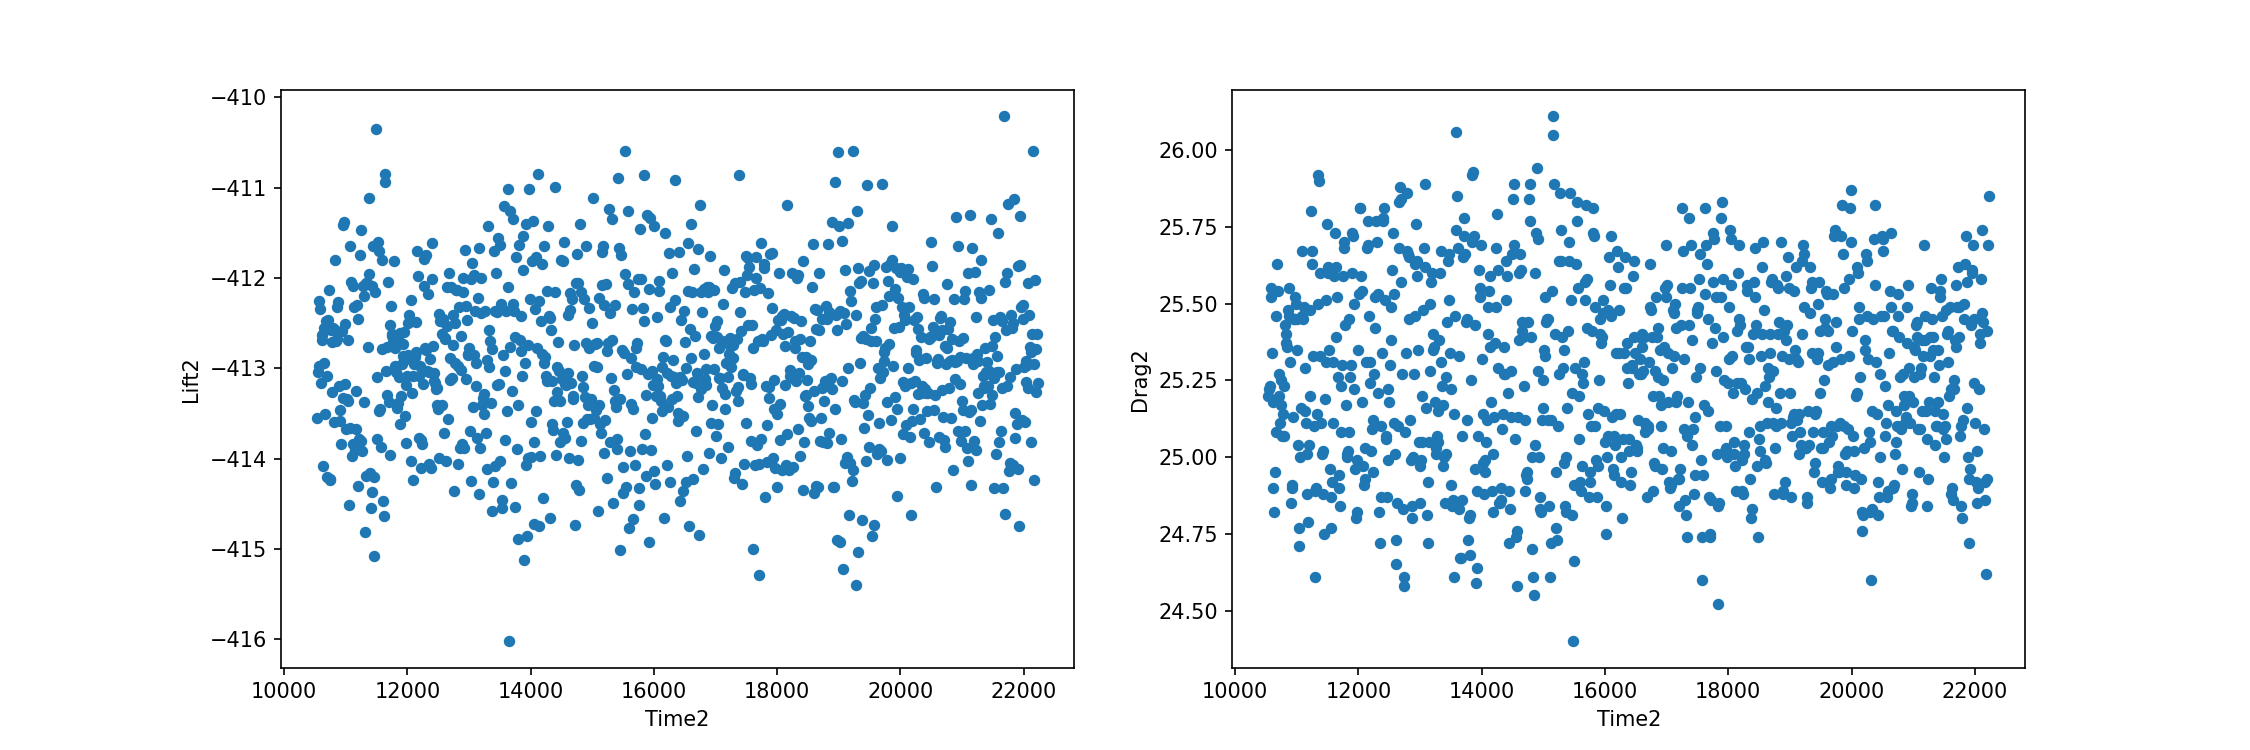

<IPython.core.display.Javascript object>


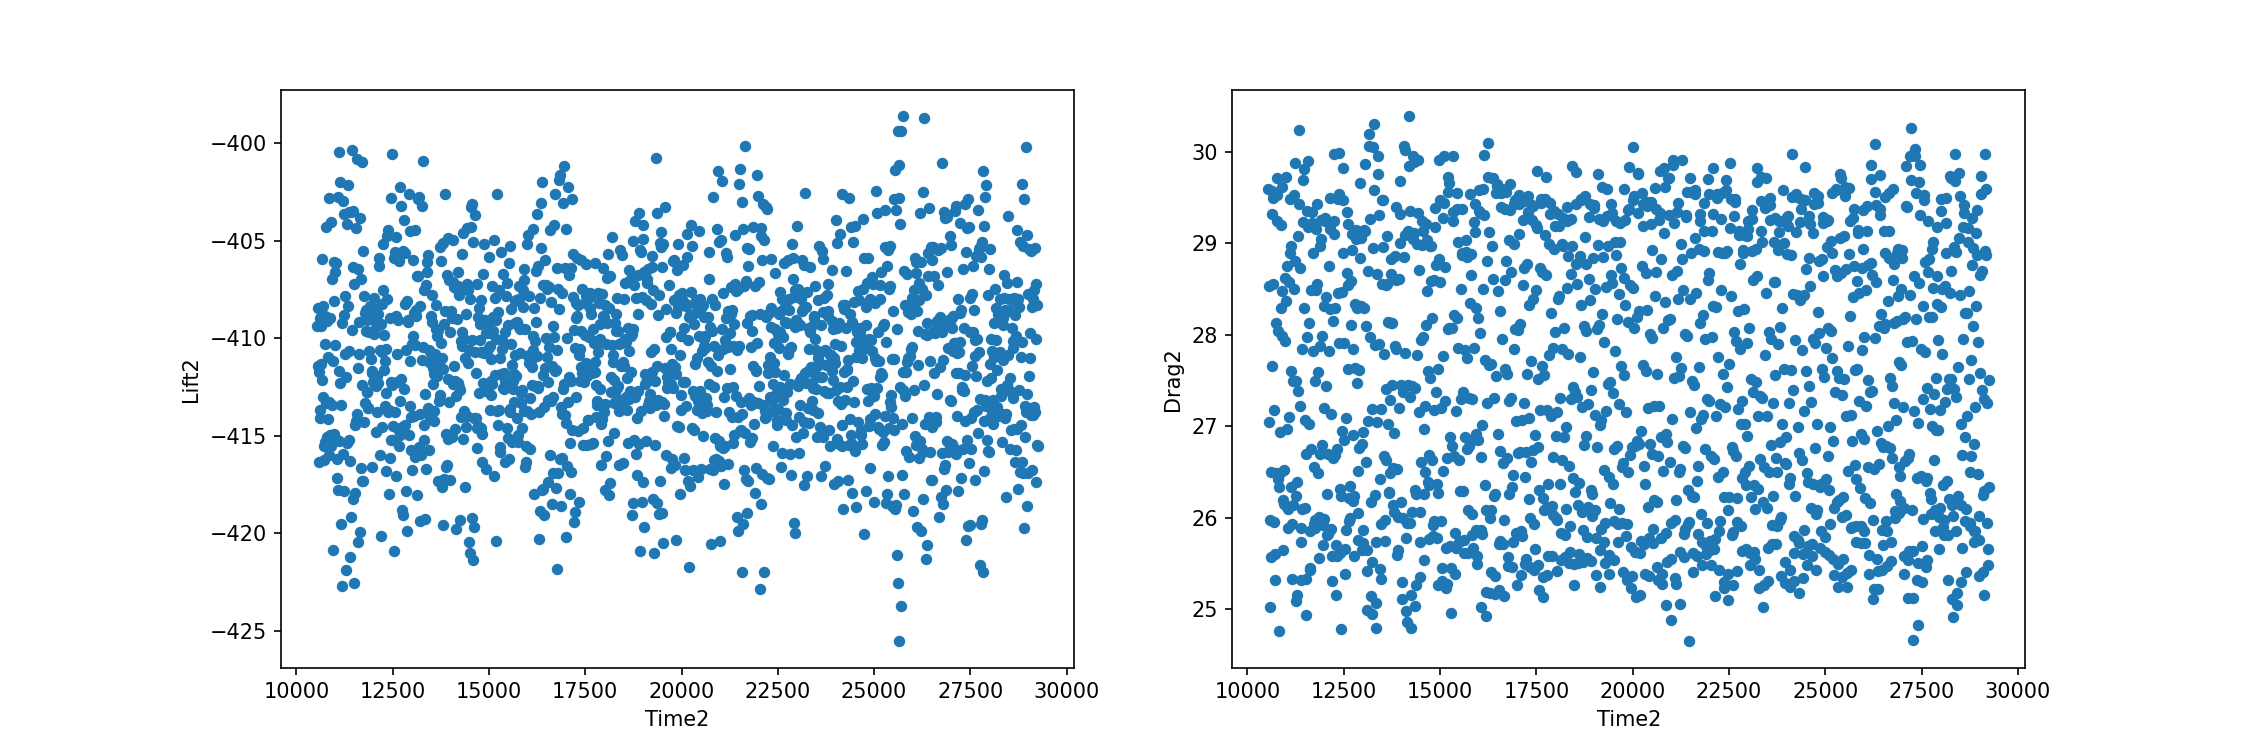

<IPython.core.display.Javascript object>


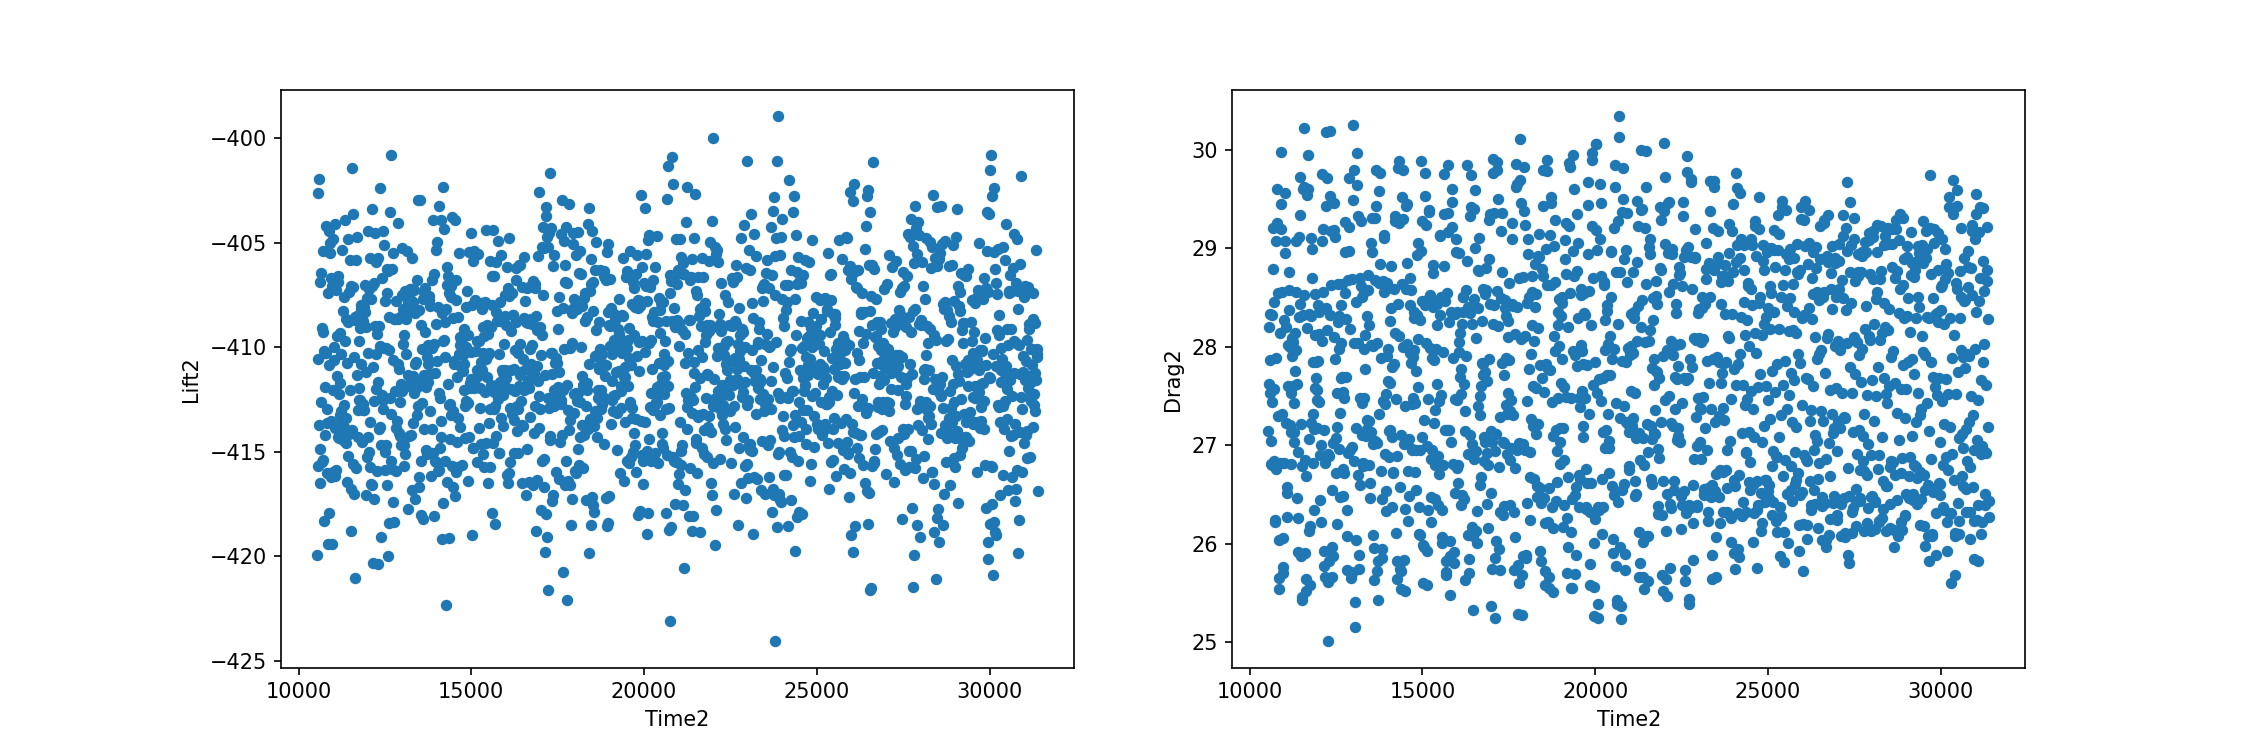

<IPython.core.display.Javascript object>


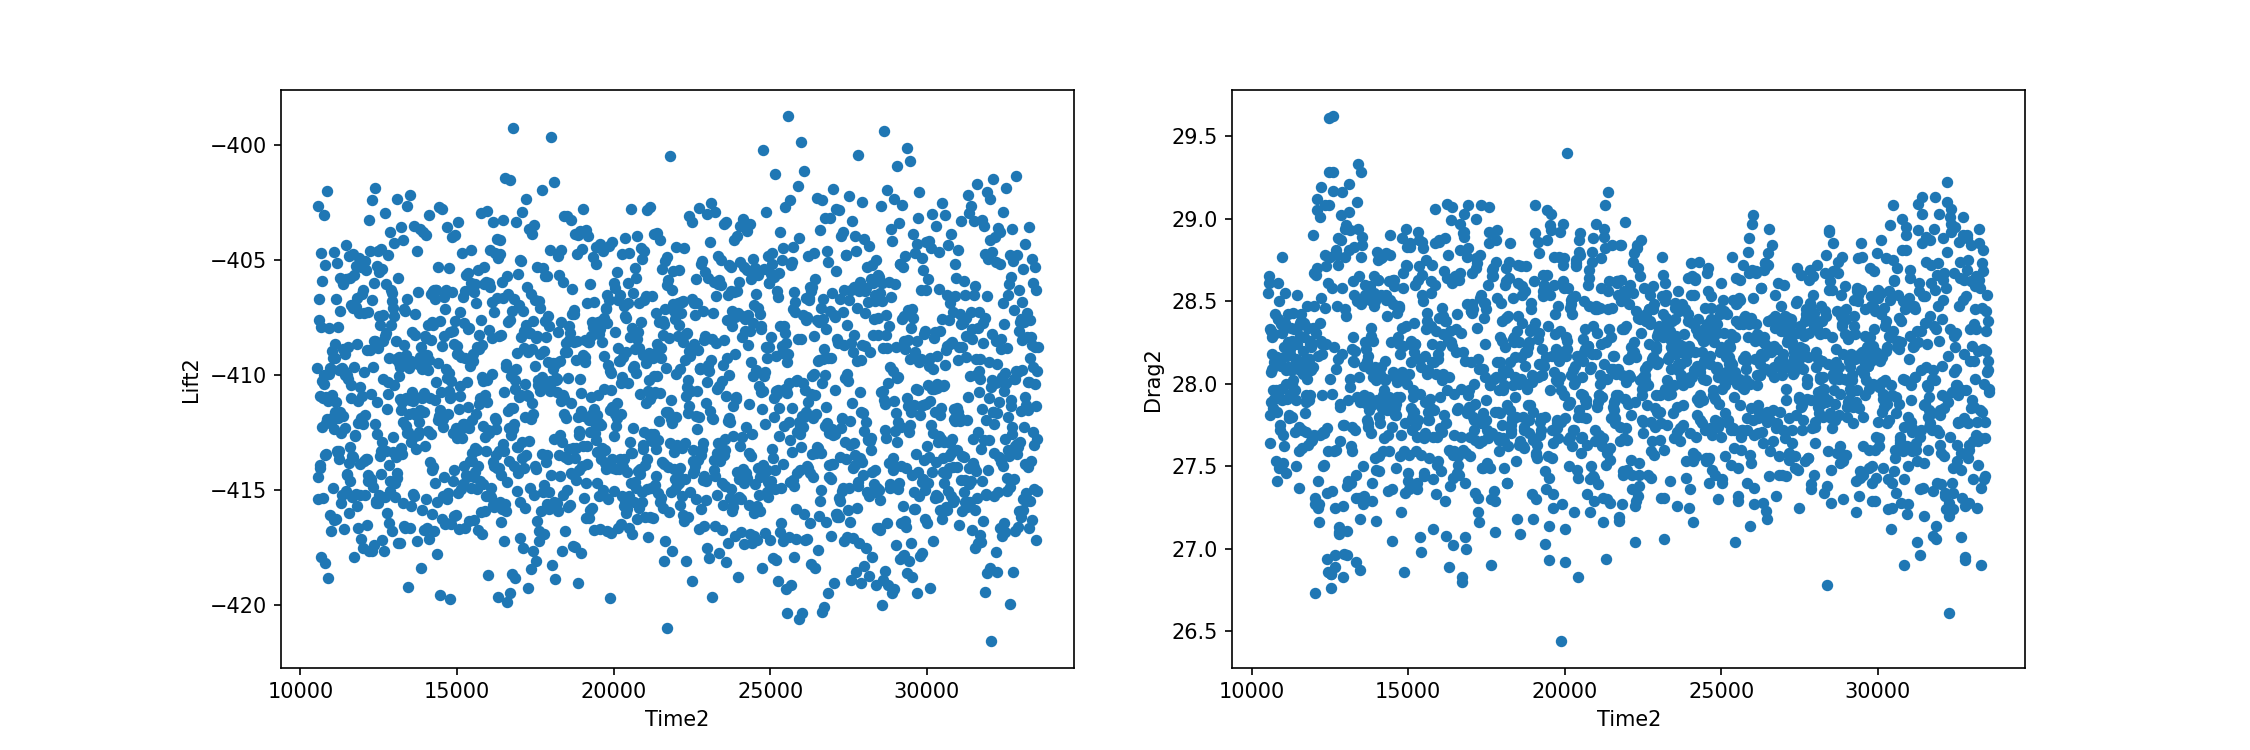

<IPython.core.display.Javascript object>


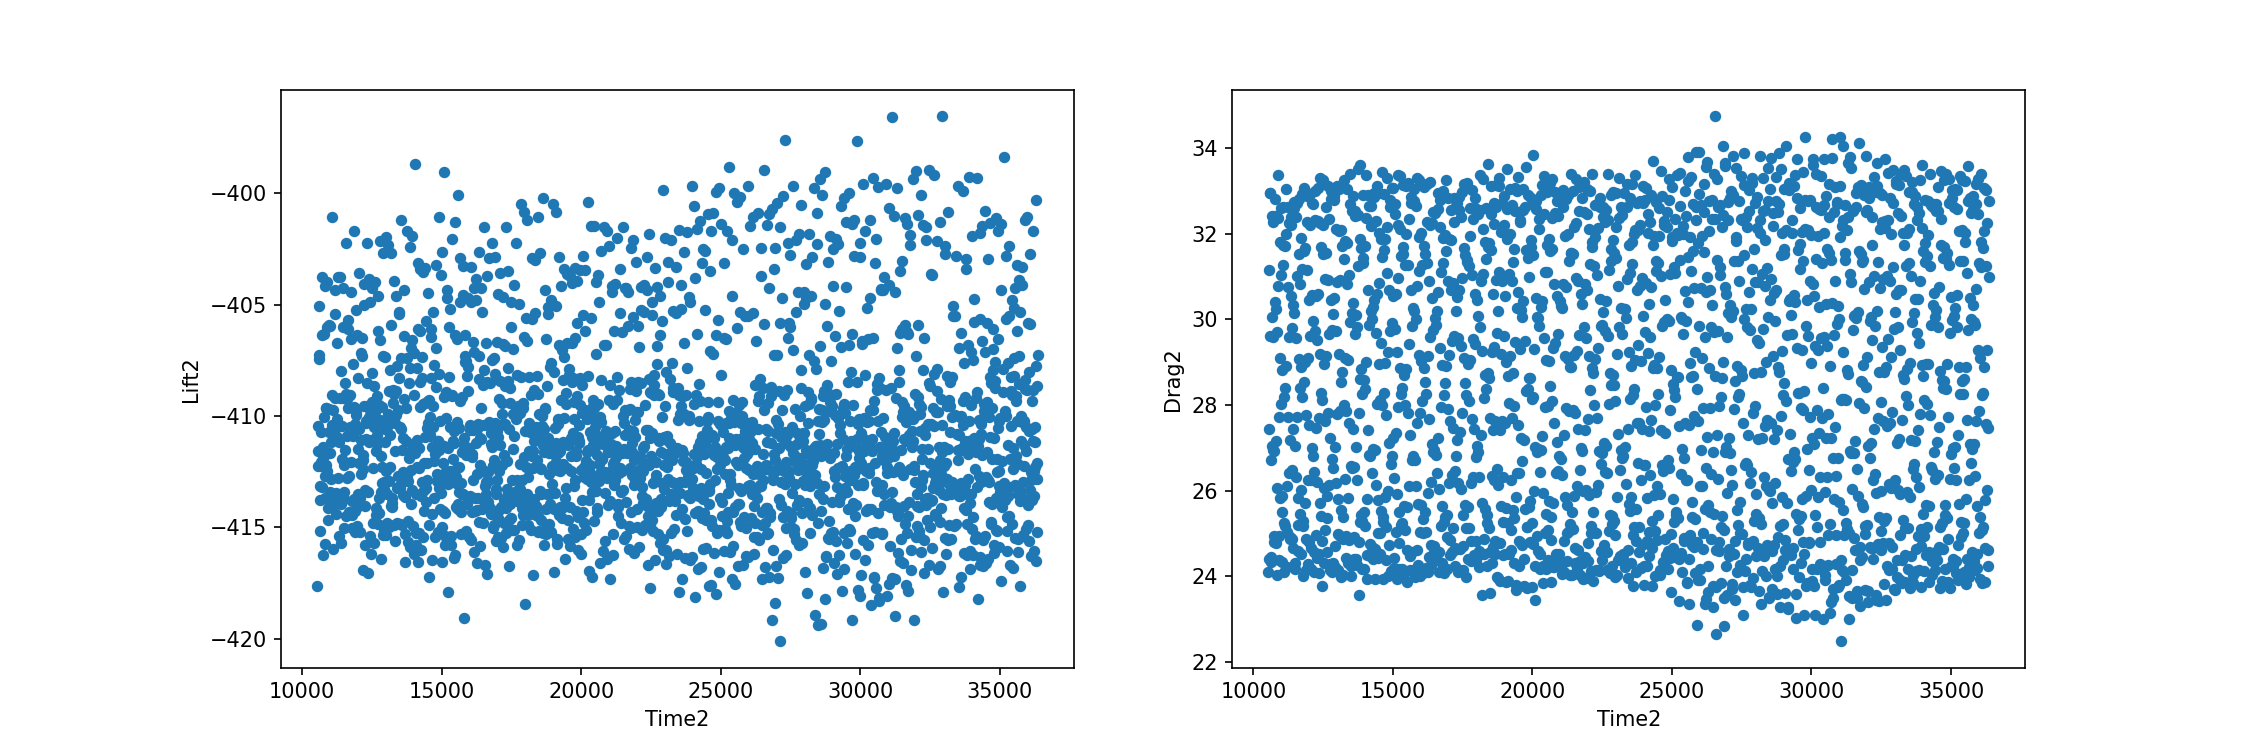

C:\Users\Santi\AppData\Local\Temp\ipykernel_7668\1389268054.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=2)


<IPython.core.display.Javascript object>


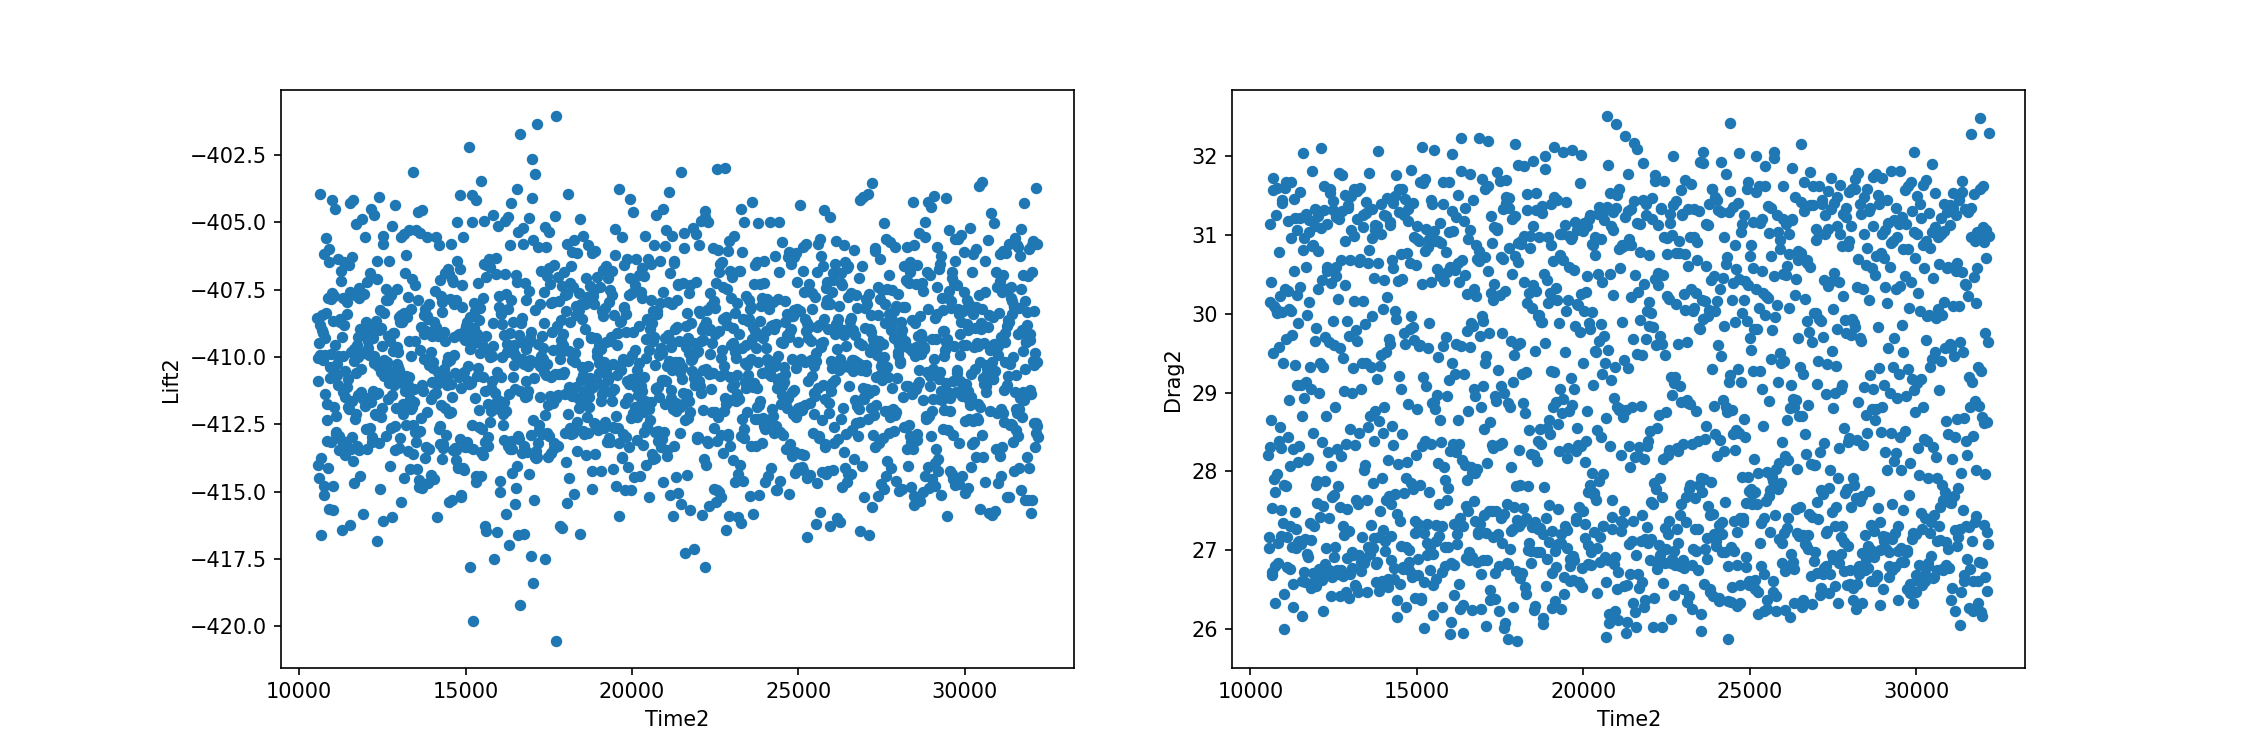

<IPython.core.display.Javascript object>


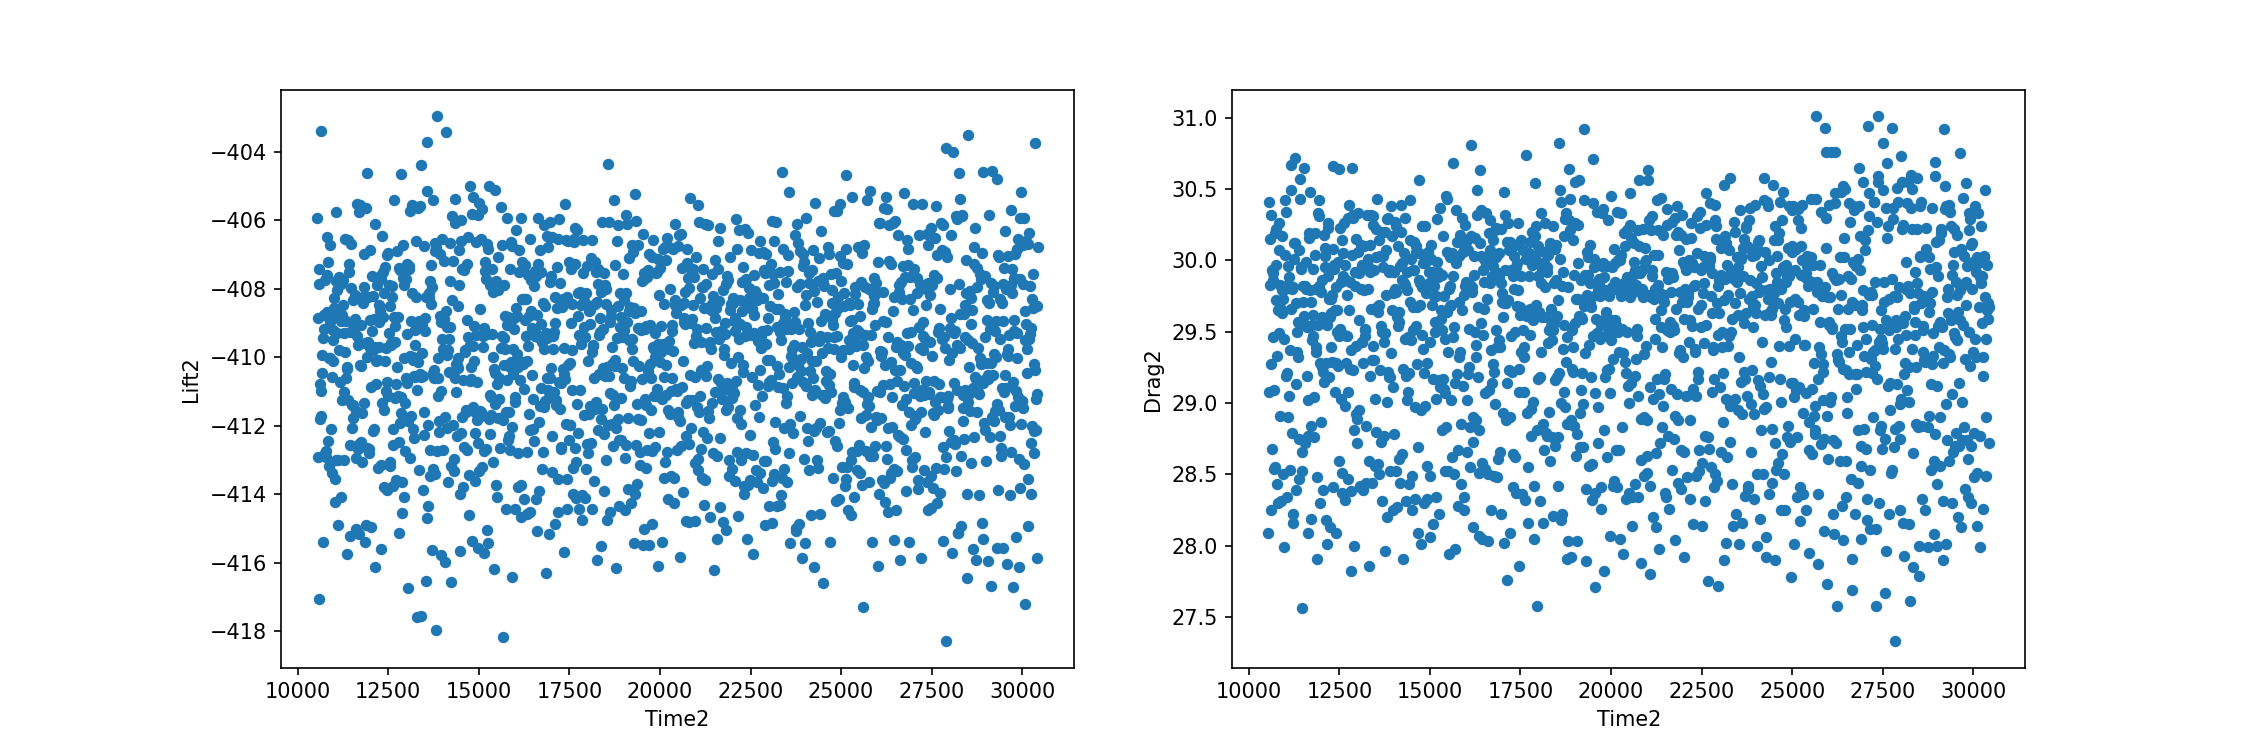

<IPython.core.display.Javascript object>


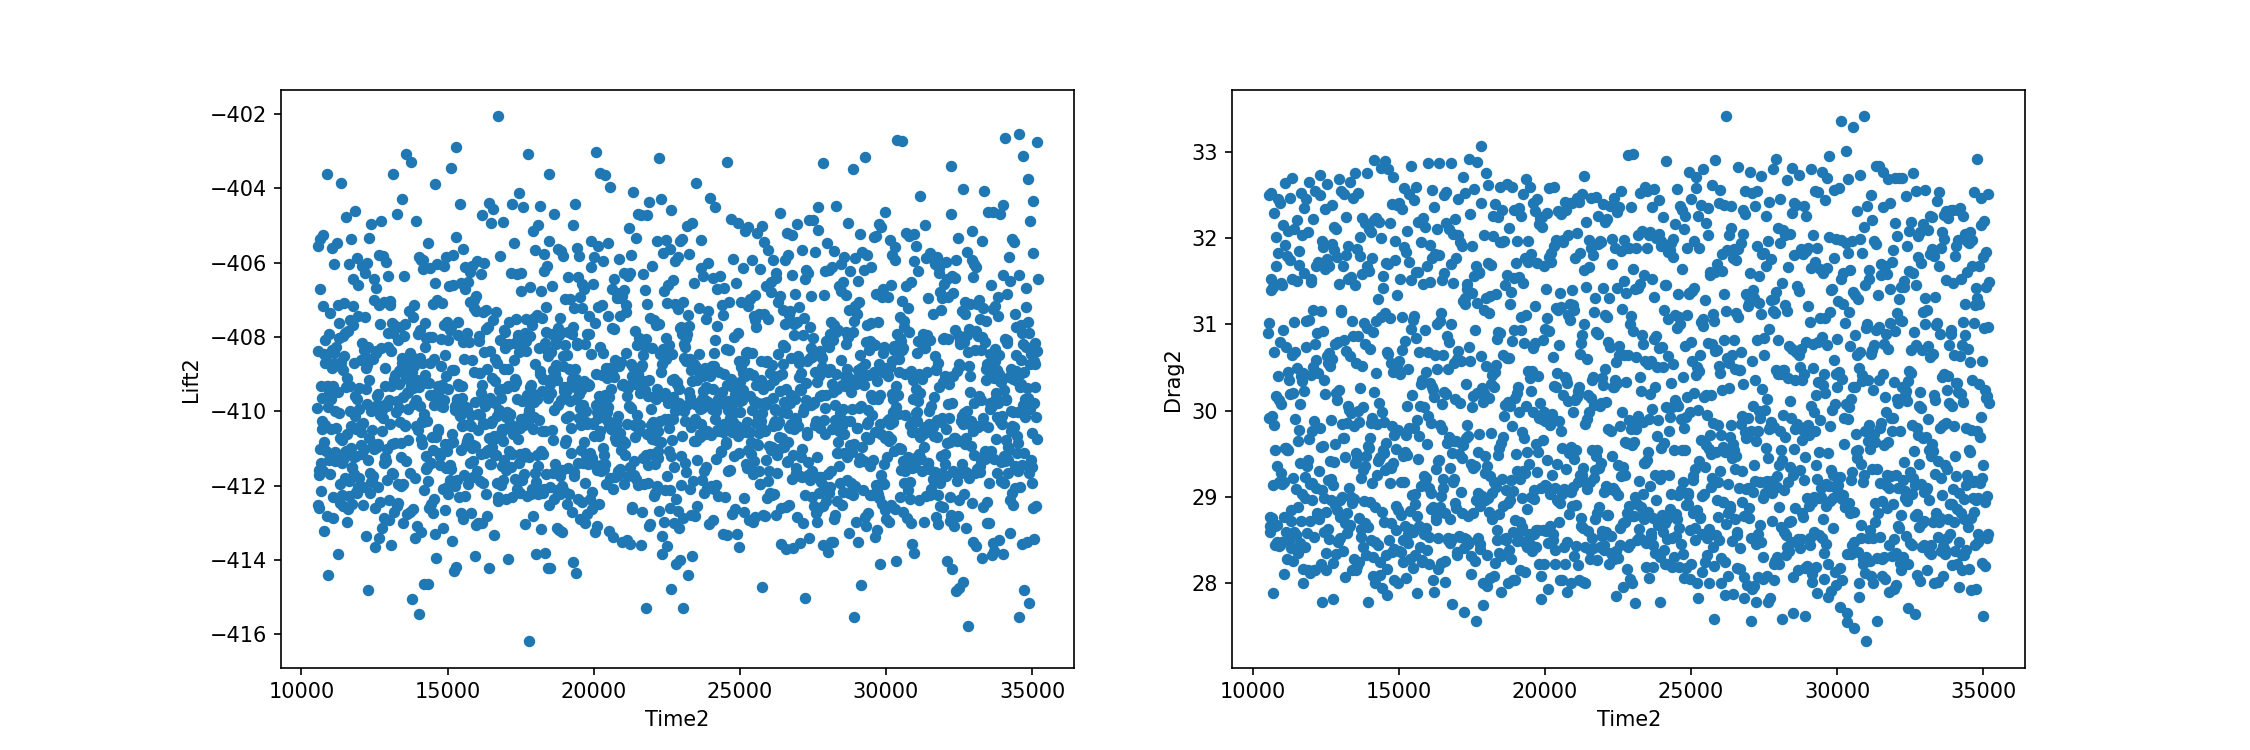

<IPython.core.display.Javascript object>


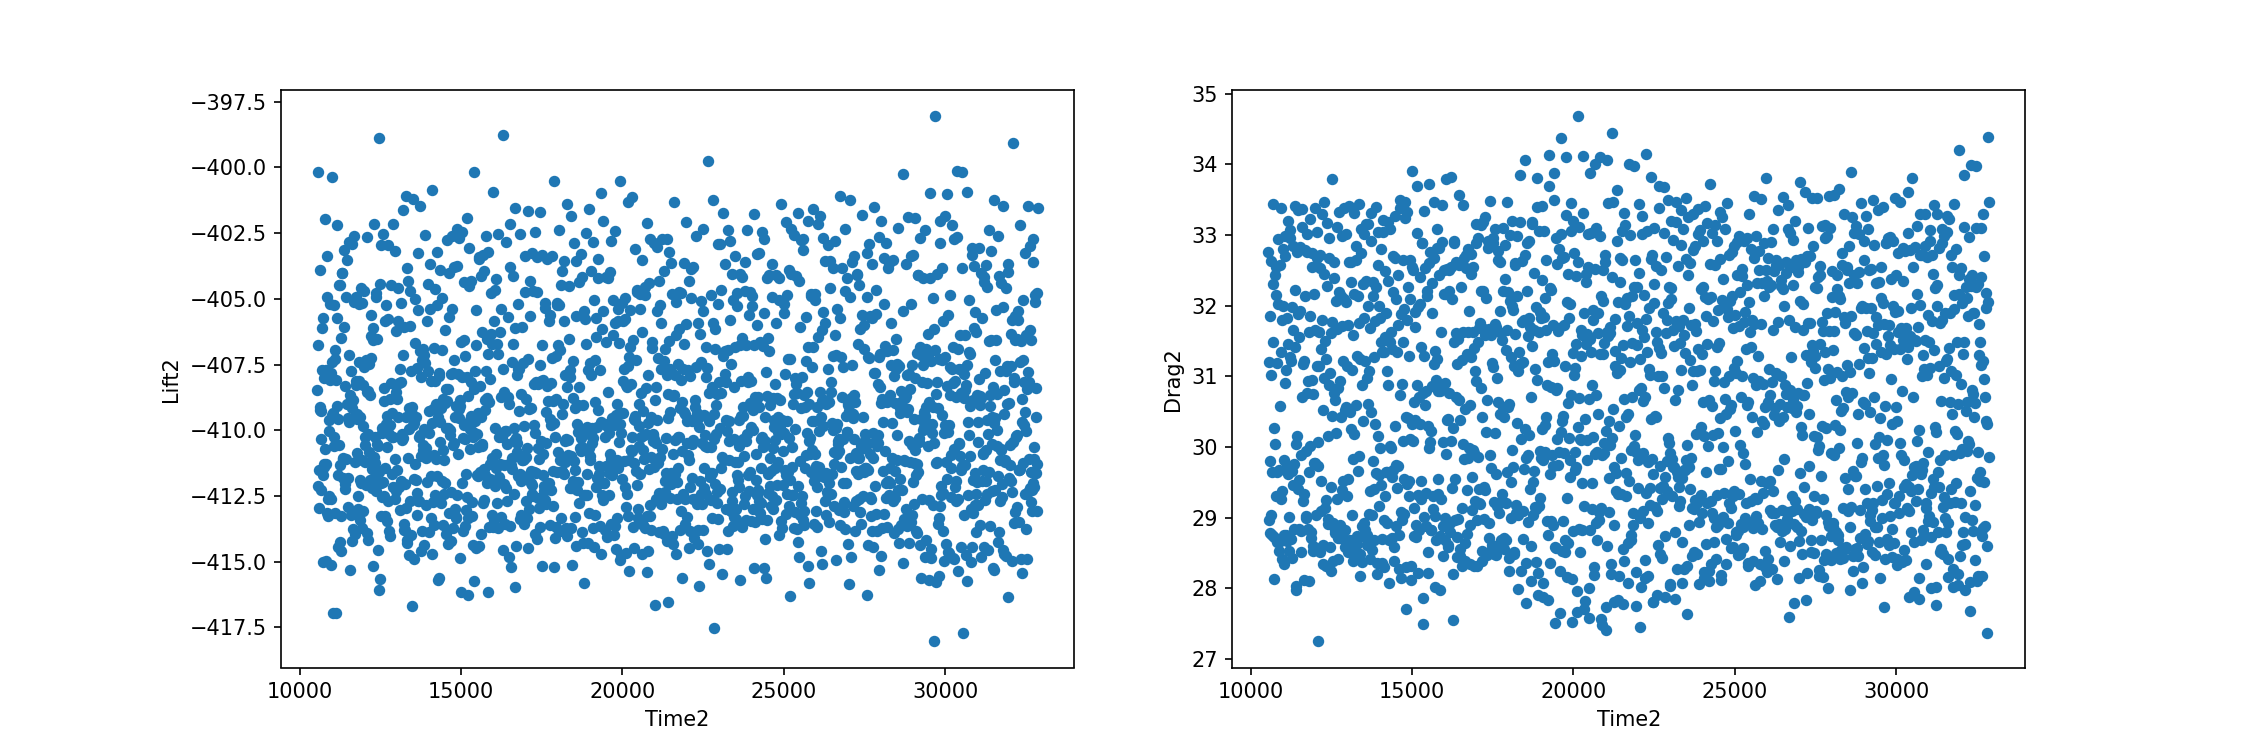

<IPython.core.display.Javascript object>


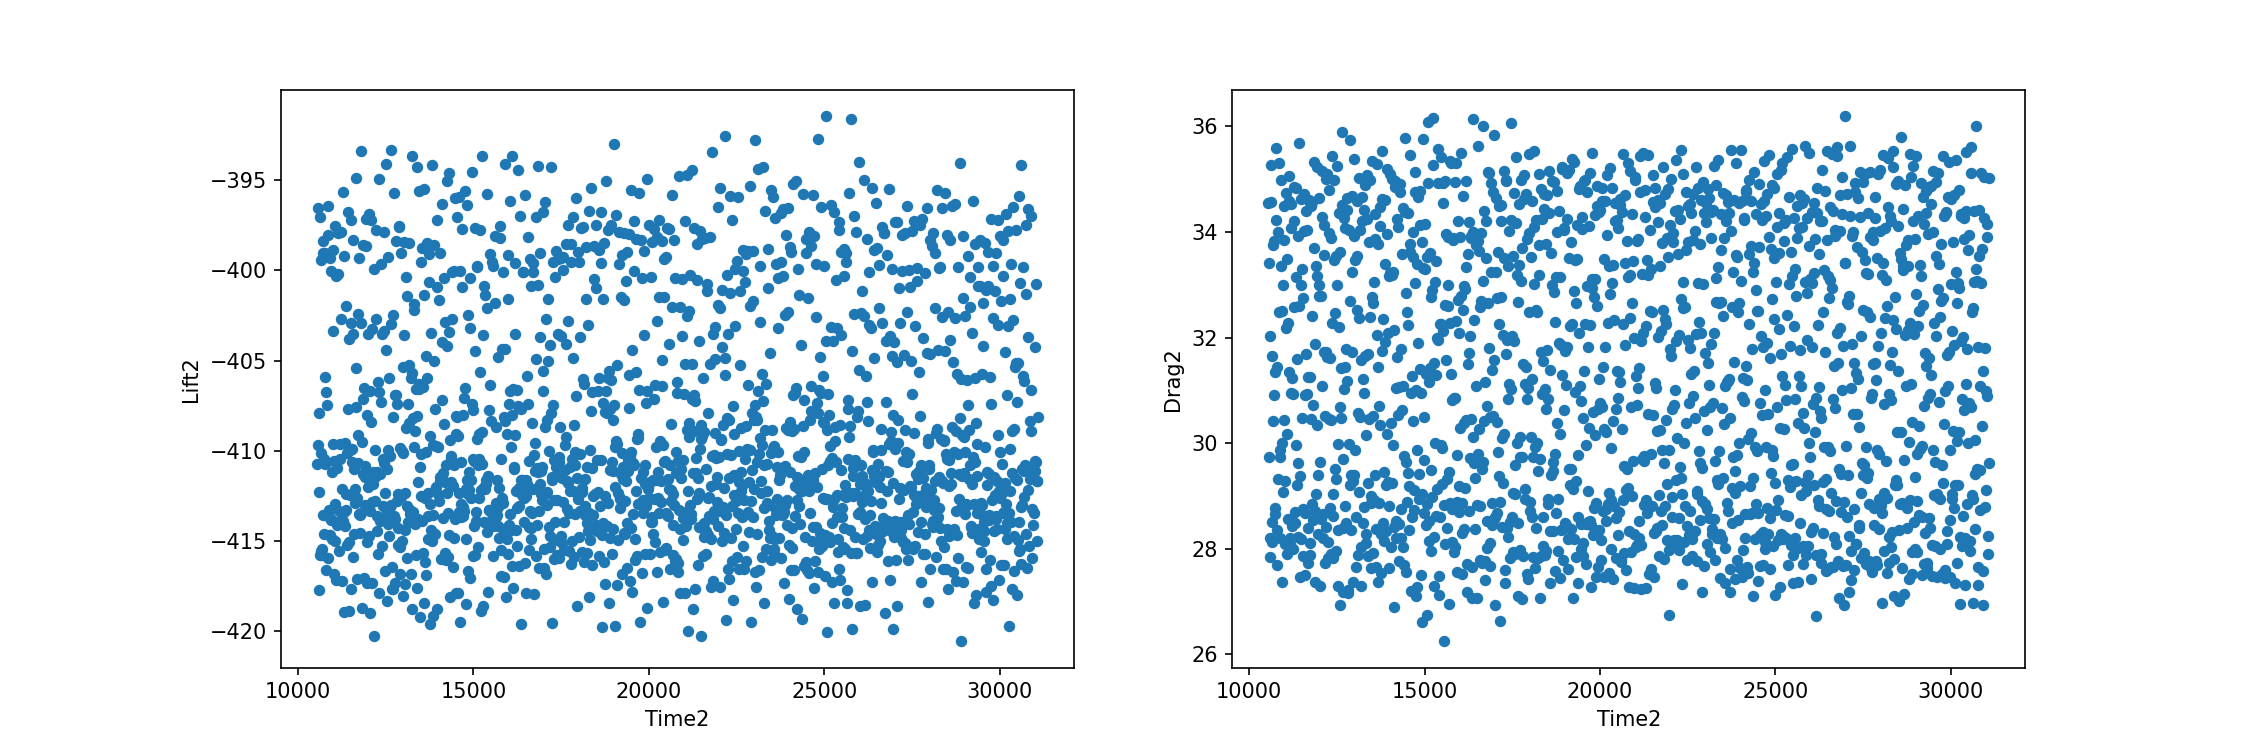

<IPython.core.display.Javascript object>


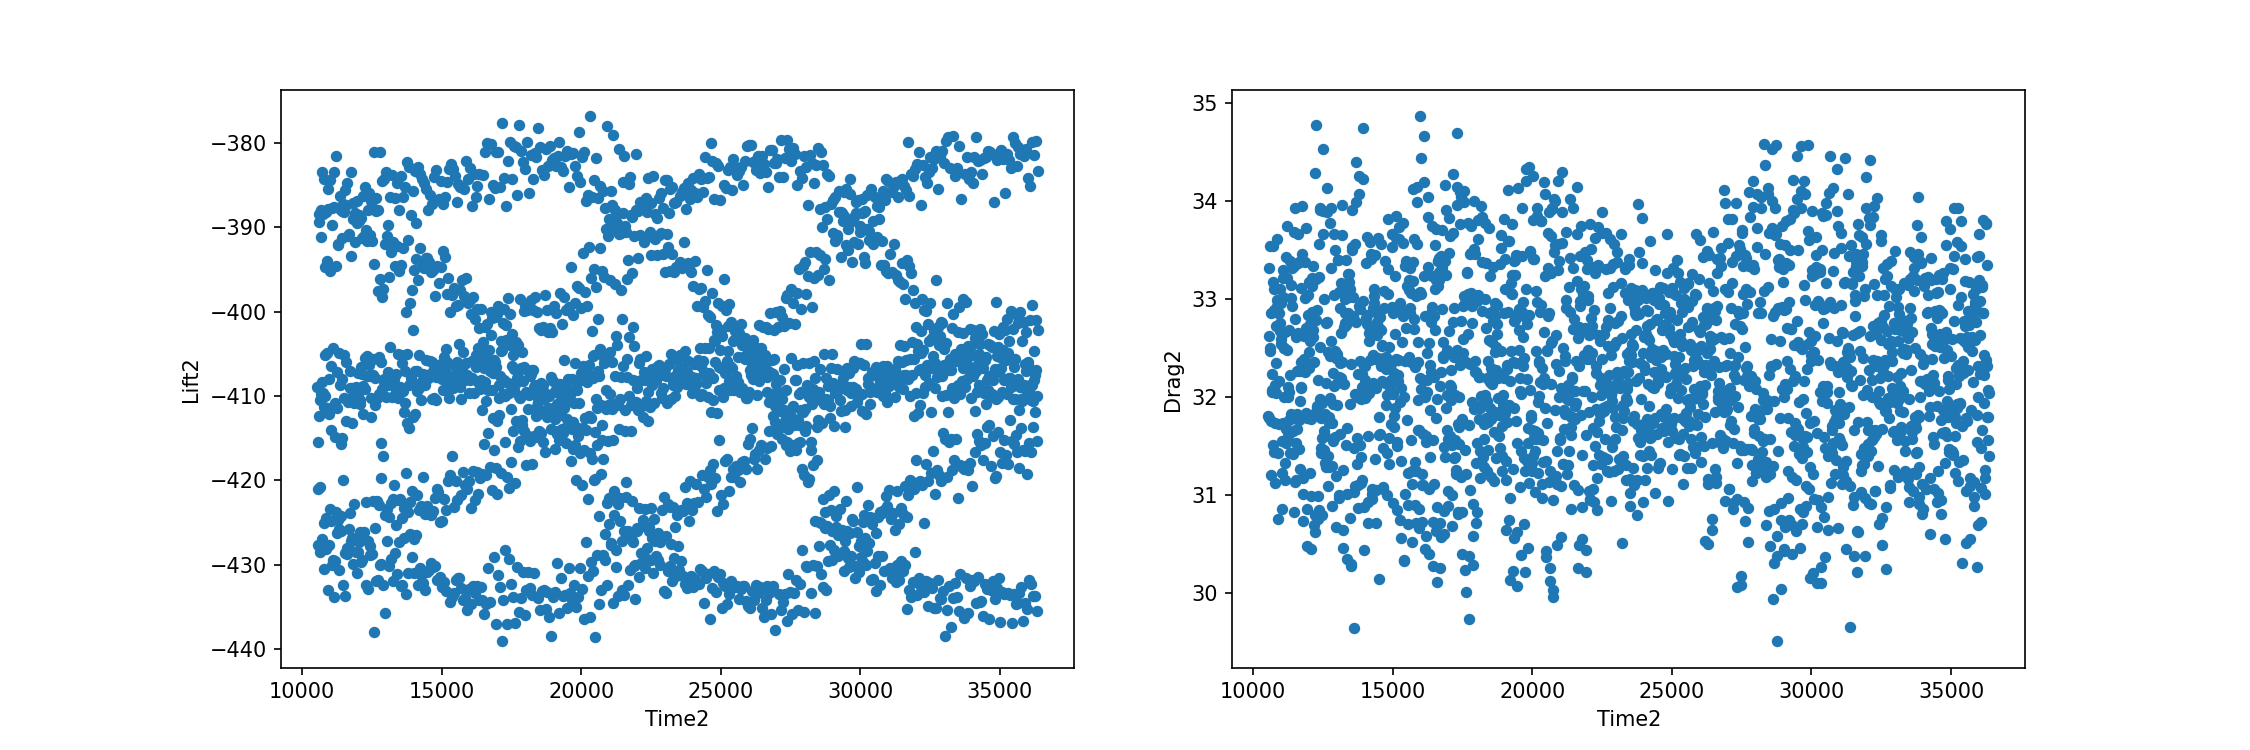

<IPython.core.display.Javascript object>


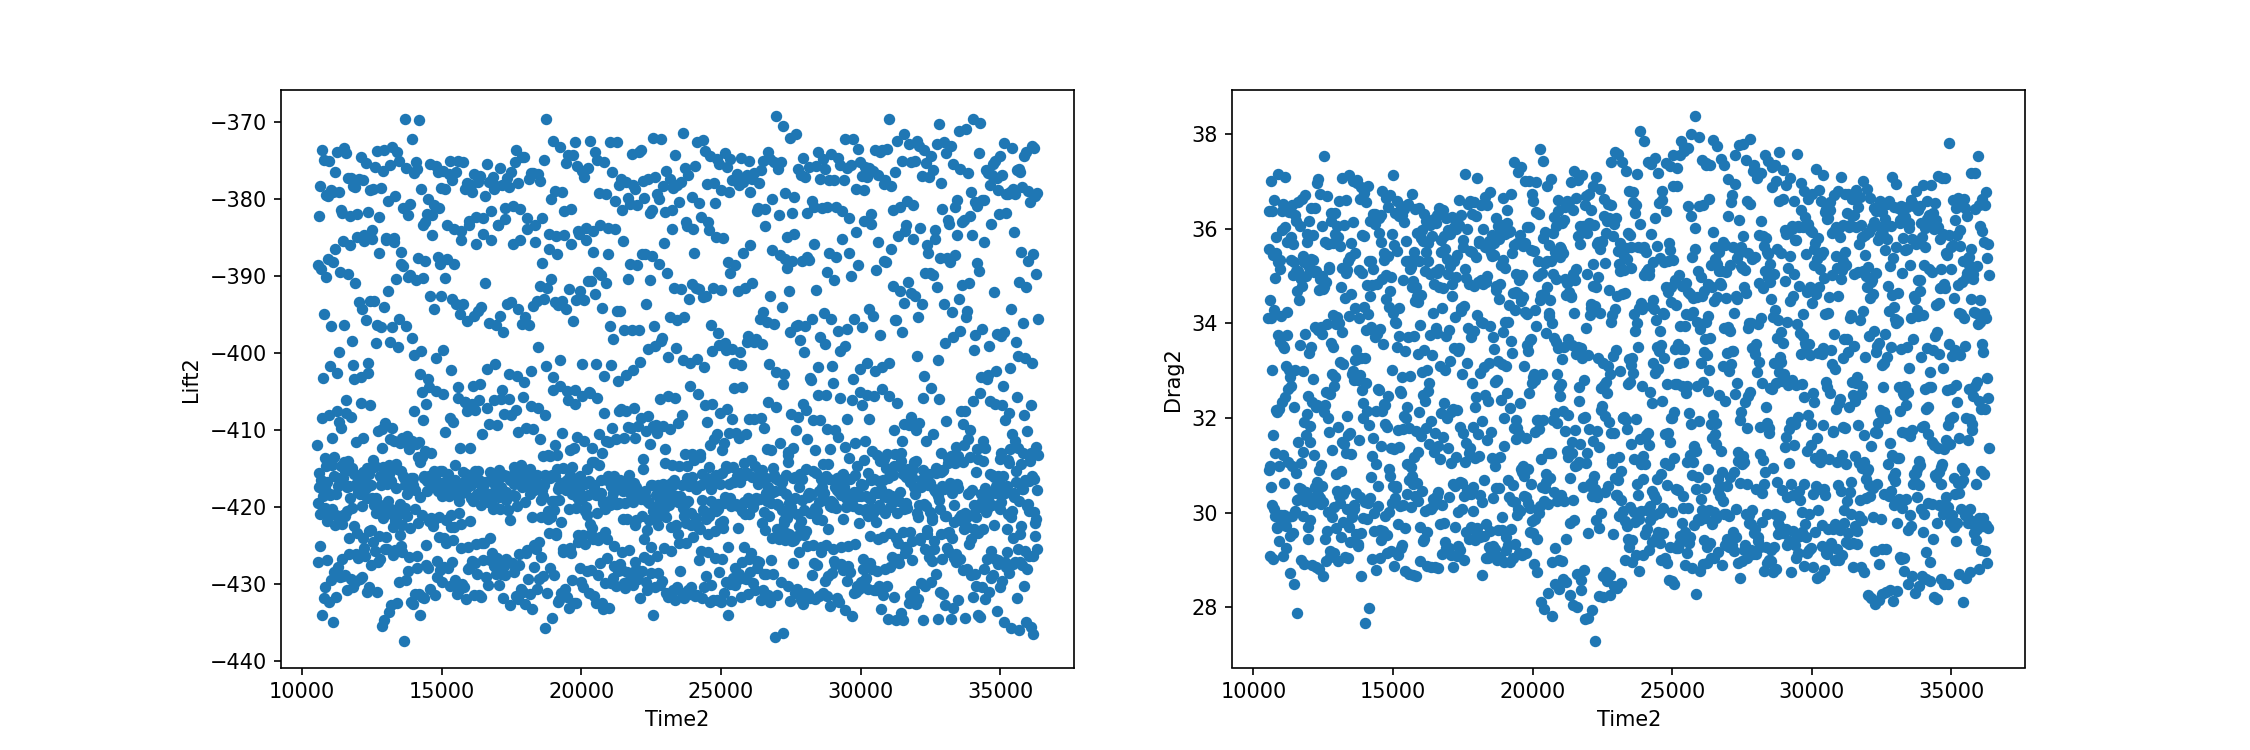

<IPython.core.display.Javascript object>


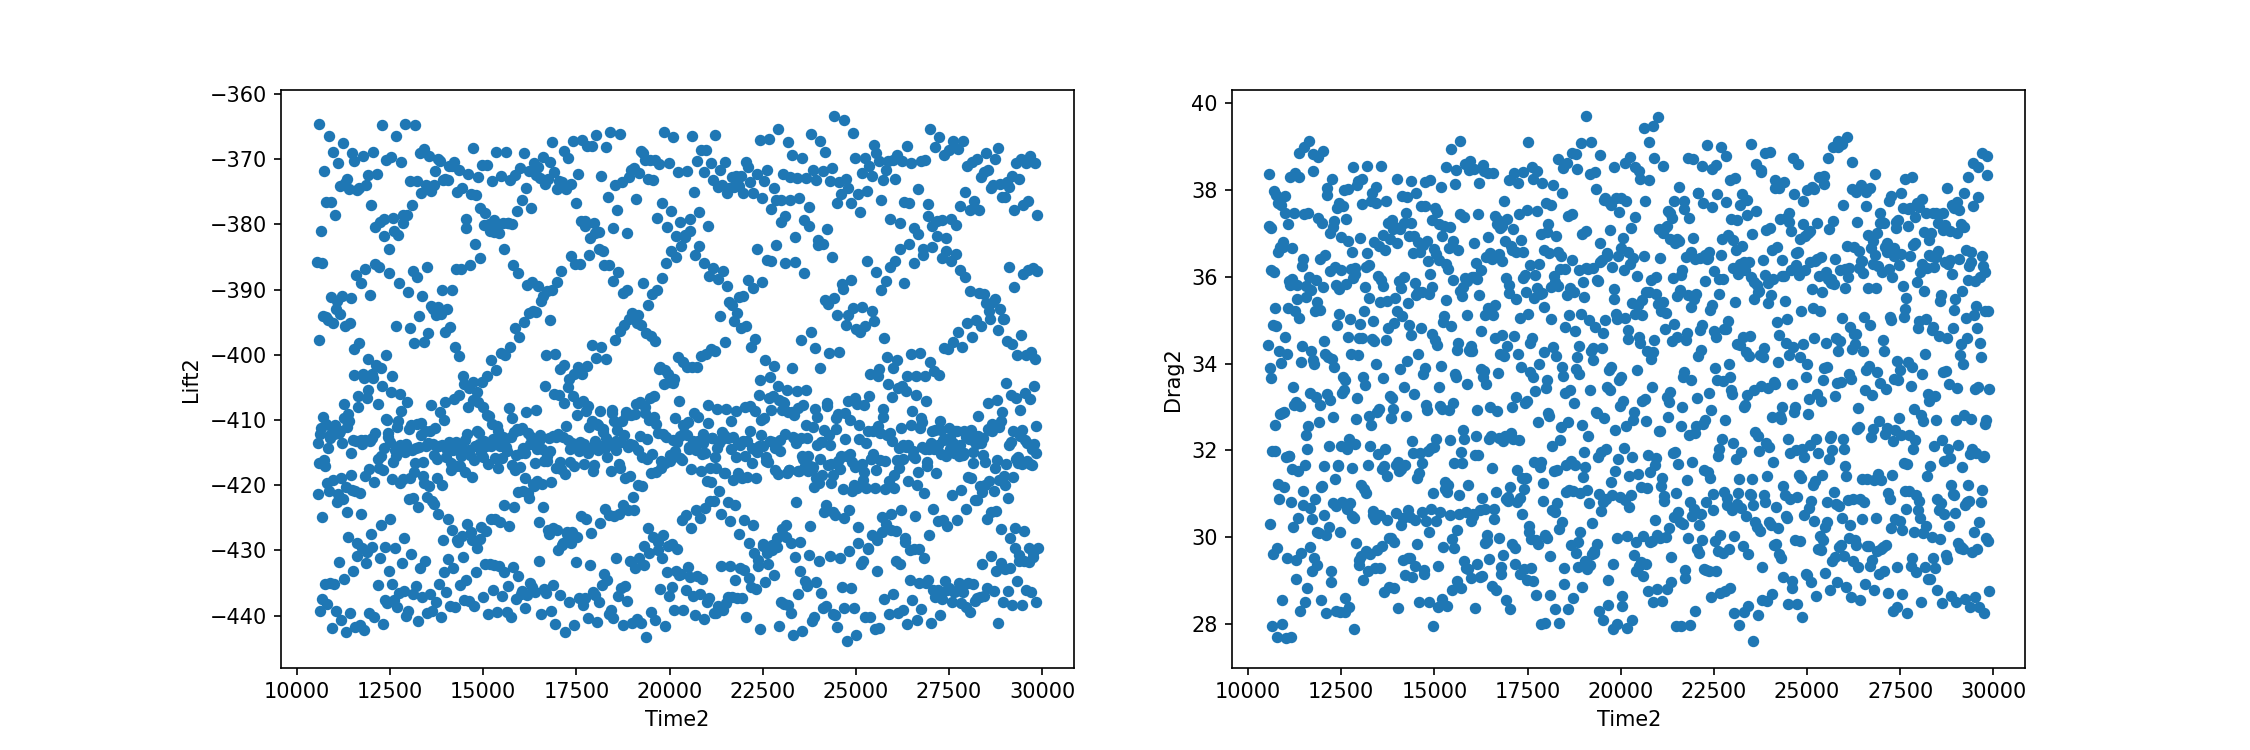

<IPython.core.display.Javascript object>


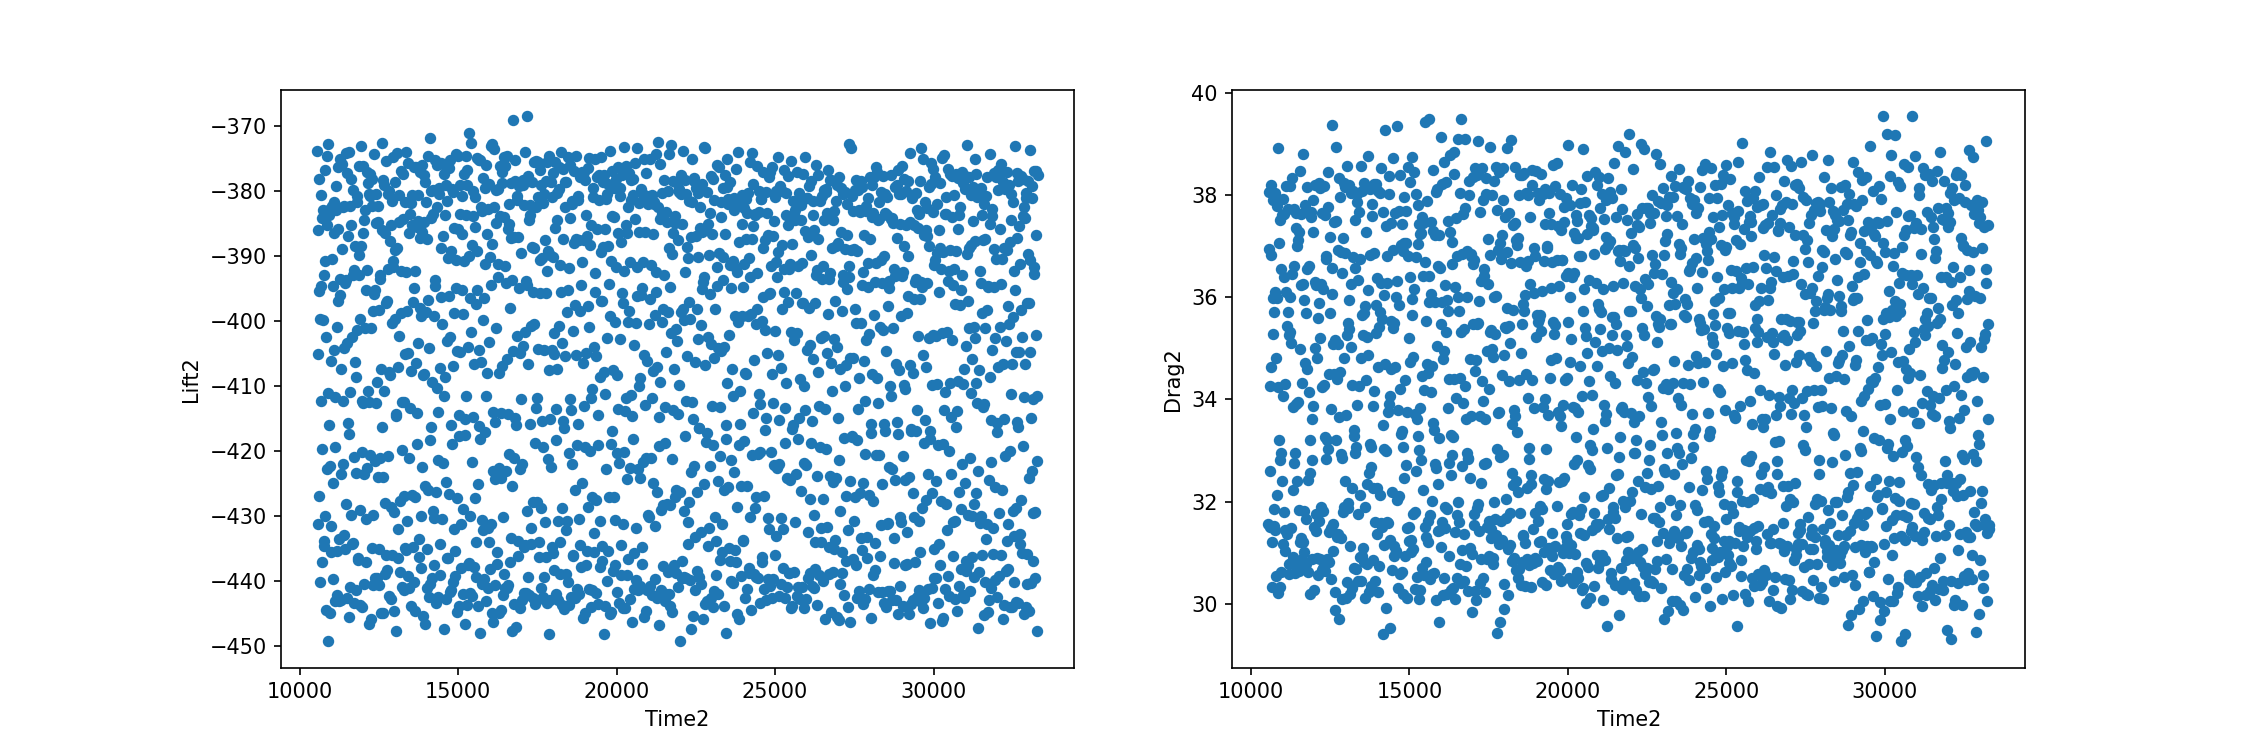

<IPython.core.display.Javascript object>


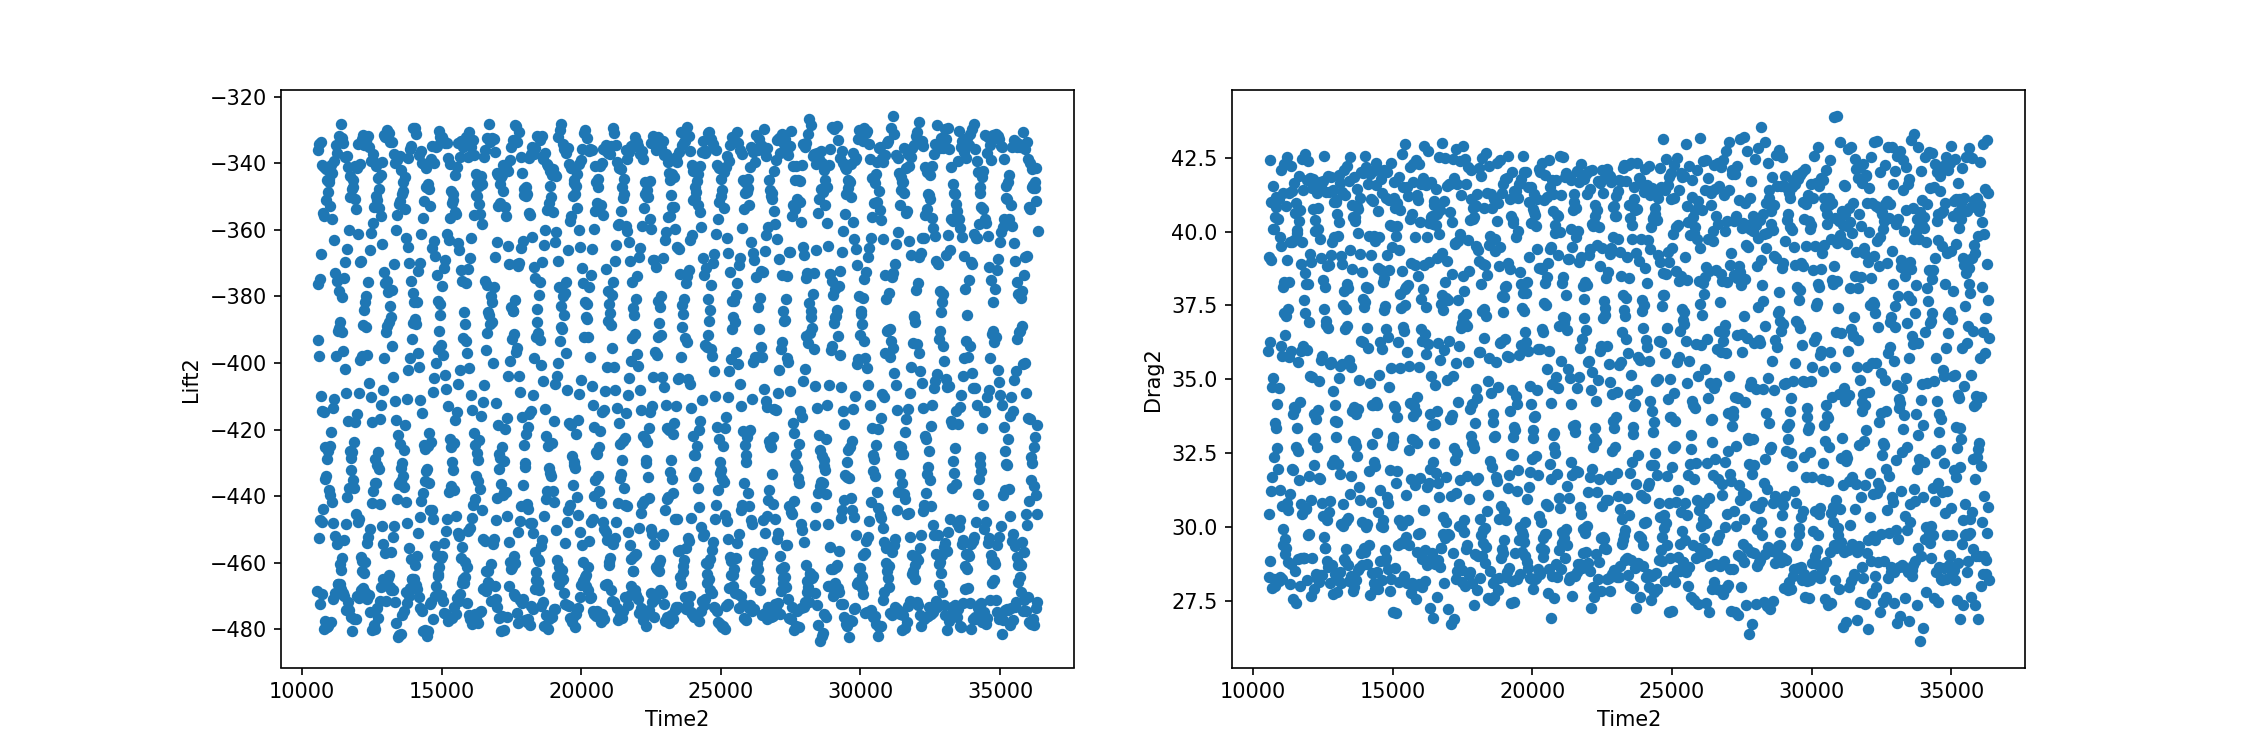

txt   MediaLift  MediaDrag
0   Raw Dataa\V00.00.txt -412.933009  25.260933
1   Raw Dataa\V25.00.txt -411.080546  27.497189
2   Raw Dataa\V26.00.txt -410.952021  27.666237
3   Raw Dataa\V28.00.txt -410.765181  28.082687
4   Raw Dataa\V30.00.txt -410.600710  28.500423
5   Raw Dataa\V32.00.txt -410.215797  28.958797
6   Raw Dataa\V34.00.txt -410.115428  29.460035
7   Raw Dataa\V36.00.txt -409.563670  30.090990
8   Raw Dataa\V38.00.txt -409.326288  30.700110
9   Raw Dataa\V40.00.txt -408.866015  31.258417
10  Raw Dataa\V42.00.txt -408.369127  32.291418
11  Raw Dataa\V44.00.txt -408.565644  32.933955
12  Raw Dataa\V46.00.txt -407.432113  33.661365
13  Raw Dataa\V48.00.txt -407.096156  34.303512
14  Raw Dataa\V50.00.txt -406.383268  35.213818

In [35]:
# en calibrationData va el nombre del archivo que 
CDfile = "CD2.txt"
CDData=open(CDfile,"w")
#CDData.write('txt,Media Lift,Media Drag,STD Lift,STD Drag\n');
CDData.write('txt,MediaLift,MediaDrag\n');

RawDataFolder = "Raw Dataa/"
files = np.sort(glob.glob(RawDataFolder+'*.txt'))
VoltajeMedicion=[]
VelocidadMedicion=[]
ReMedicion=[]
for i in files:
    item=i.strip("Raw Dataa\\V")
    item=item.strip(".txt")
    item=item.strip("")
    VoltajeMedicion.append(float(item))
    Vitem=PolinomioVelocidad[0]*float(item)+PolinomioVelocidad[1]
    VelocidadMedicion.append(Vitem)
    ReMedicion.append(Vitem*D*rho/mu)
    
Inicial= {
    "Voltaje" : VoltajeMedicion,
    "Velocidad" : VelocidadMedicion,
    "Re" : ReMedicion,
    }
DFInicial2 = pd.DataFrame(Inicial)

for k in files:
    datos = pd.read_csv(k, sep=",", header=None,skiprows=5)
    datos = datos[:-100]
    datos.columns = ["Lift2", "Drag2", "Time2"]
    datos = datos.astype(float)
    datos=datos[800:3000]
    mediaLift=datos["Lift2"].mean()
    stdLift=datos["Lift2"].std()
    mediaDrag=(datos["Drag2"].mean())
    stdDrag=(datos["Drag2"].std())
    df=datos
    
    for i in df.index:
        if df["Lift2"][i]>(mediaLift+4*stdLift):
            df["Lift2"][i]=np.nan
        if df["Lift2"][i]<(mediaLift-4*stdLift):
            df["Lift2"][i]=np.nan
        if df["Drag2"][i]>(mediaDrag+4*stdDrag):
            df["Drag2"][i]=np.nan
        if df["Drag2"][i]<(mediaDrag-4*stdDrag):
            df["Drag2"][i]=np.nan
    mediaLift=datos["Lift2"].mean()
    stdLift=datos["Lift2"].std()
    mediaDrag=datos["Drag2"].mean()
    stdDrag=datos["Drag2"].std()   
    
    for i in df.index:
        if df["Lift2"][i]>(mediaLift+4*stdLift):
            df["Lift2"][i]=np.nan
        if df["Lift2"][i]<(mediaLift-4*stdLift):
            df["Lift2"][i]=np.nan
        if df["Drag2"][i]>(mediaDrag+4*stdDrag):
            df["Drag2"][i]=np.nan
        if df["Drag2"][i]<(mediaDrag-4*stdDrag):
            df["Drag2"][i]=np.nan
    mediaLift=datos["Lift2"].mean()
    stdLift=datos["Lift2"].std()
    mediaDrag=datos["Drag2"].mean()
    stdDrag=datos["Drag2"].std()   
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(15, 5)
    df.plot.scatter(ax=axes[0],x="Time2", y="Lift2")
    df.plot.scatter(ax=axes[1],x="Time2", y="Drag2")
    fig.savefig(k+".png", dpi=100)
    
    # Las lineas vienen como #.txt,mediaL,mediaD,stdL,stdD
    #CDData.write(i+","+str(mediaLift)+","+str(mediaDrag)+","+str(stdLift)+","+str(stdDrag)+"\n")
    CDData.write(str(k)+","+str(mediaLift)+","+str(mediaDrag)+"\n")
    
CDData.close()
DFFinal2=pd.read_csv(CDfile)
DFFinal2

In [36]:
DatosCD=pd.concat([DFFinal,DFInicial],axis =1)
DatosCD2=pd.concat([DFFinal2,DFInicial2],axis =1)

In [37]:
## Tomo la referencia y la borro del original


Referencia=DatosCD[:1]
Drag0=Referencia["MediaDrag"][0]
Lift0=Referencia["MediaLift"][0]
DatosCD=DatosCD.drop([0]) 


Referencia2=DatosCD2[:1]
Drag02=Referencia2["MediaDrag"][0]
Lift02=Referencia2["MediaLift"][0]
DatosCD2=DatosCD2.drop([0]) 

In [38]:
### Uso la referencia para poner en 0 todo
DatosCD["Drag"]= DatosCD["MediaDrag"]-Drag0
DatosCD["Lift"]= DatosCD["MediaLift"]-Lift0

DatosCD2["Drag"]= DatosCD2["MediaDrag"]-Drag02
DatosCD2["Lift"]= DatosCD2["MediaLift"]-Lift02

In [39]:
DatosCD["Drag"]= DatosCD["Drag"]-DatosCD2["Drag"]
DatosCD["Lift"]= DatosCD["Lift"]-DatosCD2["Lift"]

In [40]:
#limpio los datos que ya no me sirven

DatosCD=DatosCD.drop("txt", axis=1)
DatosCD=DatosCD.drop("MediaDrag", axis=1)
DatosCD=DatosCD.drop("MediaLift", axis=1)

In [44]:
DatosCD["CD"]=np.abs(DatosCD["Drag"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"]))
DatosCD["CL"]=np.abs(DatosCD["Lift"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"]))

In [45]:
DatosCD

Voltaje  Velocidad            Re       Drag       Lift        CD        CL
1     25.00   2.167614   6825.935609 -22.744056   5.685614  4.657196  1.164217
2     26.01   2.260036   7116.975955 -21.148611   6.007230  3.983565  1.131525
3     28.00   2.442134   7690.411885 -20.717371   6.487013  3.342077  1.046469
4     30.00   2.625147   8266.729403 -19.434774   7.225392  2.713270  1.008730
5     32.00   2.808159   8843.046920 -18.431314   7.876770  2.248710  0.961004
6     34.00   2.991172   9419.364438 -16.373927   9.297438  1.760721  0.999772
7     36.00   3.174185   9995.681955 -15.535722   9.911560  1.483500  0.946451
8     38.00   3.357198  10571.999473 -14.417417  10.934791  1.230706  0.933420
9     40.00   3.540211  11148.316990 -13.072871  11.899811  1.003537  0.913487
10    42.00   3.723224  11724.634508 -12.280642  11.643330  0.852321  0.808090
11    44.00   3.906237  12300.952025 -12.923178  11.839847  0.814841  0.746534
12    46.00   4.089250  12877.269543  -9.845311  13.565153  0.566452  0.780473
13    48.00   4.272262  13453.587060  -8.005522  14.813601  0.421983  0.780846
14    50.00   4.455275  14029.904578  -6.255914  16.152542  0.303223  0.782911

<IPython.core.display.Javascript object>


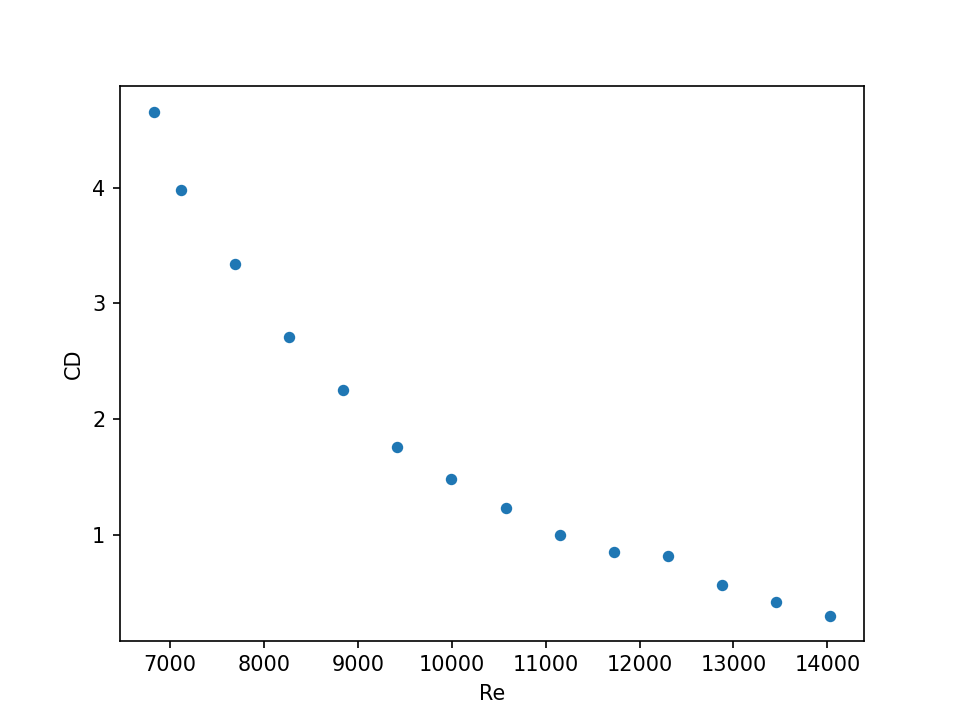

<AxesSubplot:xlabel='Re', ylabel='CD'>

In [46]:
DatosCD.plot.scatter(x="Re", y="CD")